# Main workflow:
* Modular implementation.  
* High level programming (layer architecture).  
* Import low level functions from a python script.  

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%load_ext autoreload
%autoreload 2
import importlib

import FusionModel_withVGG_tools as fm
importlib.reload(fm)

import Image_Preprocessing_DL_tools as ipdl
importlib.reload(ipdl)

import VGG_model_tools as vggt
importlib.reload(vggt)

import nltk
# nltk.download('popular', quiet = True)

import os
import time

In [2]:
## define general parameters

myseed = 123

# splitting_path = '../Splitted_datasets/'
preprocessing_path = '../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/'
# training_path = '../Trained_models_and_metrics/'
images_path = '../datasets/image_train/'

## these are to test if run twice:
fm_splitting_path = '../fm/Splitted_datasets/'
# fm_preprocessing_path = '../fm/Preprocessed_data/'

## to save models and small data from this notebook only
fm_training_path = '../fm/Trained_models/'

### product categories

In [3]:
product_class = pd.read_csv('../datasets/product_class.csv', sep = ';')
product_class.drop('target', axis = 1, inplace = True)
print(product_class.shape)
product_class.head()

(27, 2)


,prdtypecode,prodtype
0,10,livres_adulte
1,40,jeux_videos_import
2,50,accessoires_jeux_videos
3,60,jeux_et_consoles_retro
4,1140,goodies_geek


# 1 - Import raw dataset (Optional)
* Define train & test splits
* Split entire dataset once here to avoid any issues (information leak, etc)

### Import raw datasets: features and targets

In [17]:
## import raw datasets: features and target
df_X = pd.read_csv('../datasets/X_train_update.csv', index_col = 0)
df_y = pd.read_csv('../datasets/Y_train_CVw08PX.csv', index_col = 0).squeeze()  ## for correct splitting

print(type(df_X), type(df_y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [18]:
display(df_X.head())
print(df_X.index)

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            84906, 84907, 84908, 84909, 84910, 84911, 84912, 84913, 84914,
            84915],
           dtype='int64', length=84916)


In [19]:
display(df_y.head())
print(df_y.index)

0      10
1    2280
2      50
3    1280
4    2705
Name: prdtypecode, dtype: int64

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            84906, 84907, 84908, 84909, 84910, 84911, 84912, 84913, 84914,
            84915],
           dtype='int64', length=84916)


### Define train test splitting
* [x] define the splitting for the val ann train subsets
* [ ] then use the 2308242016_df_X_train_subset, 2308242016_df_X_val_subset and 2308141811_df_X_test

In [21]:
from sklearn.model_selection import train_test_split

## train-test split raw data
data_X_train, df_X_test, data_y_train, df_y_test = train_test_split(df_X, df_y, test_size = 0.2, \
                                                                random_state = myseed, stratify = df_y)

## train val split raw data: 
## ATENTION: Pass a dataframe for stratify (NOT a Series object)
df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(data_X_train, data_y_train.to_frame(), test_size = 0.2, \
                                                                random_state = myseed, stratify = data_y_train.to_frame())

### Save splitted datasets

In [25]:
## save splitted dataframes
fm.save(datasets = [df_X_train, df_X_val, df_X_test, df_y_train, df_y_val, df_y_test], \
             types = ['dataframe']*6, \
             names = ['df_X_train', 'df_X_val', 'df_X_test', 'df_y_train', 'df_y_val', 'df_y_test'], \
              path = fm_splitting_path , doit = False, verbose = True)  #


Saved dataset: ../fm/Splitted_datasets/2308261622_df_X_train.csv
Saved dataset: ../fm/Splitted_datasets/2308261622_df_X_val.csv
Saved dataset: ../fm/Splitted_datasets/2308261622_df_X_test.csv
Saved dataset: ../fm/Splitted_datasets/2308261622_df_y_train.csv
Saved dataset: ../fm/Splitted_datasets/2308261622_df_y_val.csv
Saved dataset: ../fm/Splitted_datasets/2308261622_df_y_test.csv


<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
    From now on, the <b>test dataset</b> will only be used to asses the models performance
</div>

# 2- Image data
Start to do preprocessing since it will define the order in which text data has ti be preprocessed.

## 2.1 Preprocess Images: crop, resize and save in another directory

In [26]:
ipdl.crop_resize_images(df_X_train, threshold = 230, new_pixel_nb = 224, 
                        path = images_path, 
                        new_dir = fm_splitting_path + 'Images_224px/Train_subset', 
                        verbose = True)

created folder ../fm/Splitted_datasets/Images_224px/Train_subset
1000 images at time 0.18 minutes
2000 images at time 0.36 minutes
3000 images at time 0.53 minutes
4000 images at time 0.70 minutes
5000 images at time 0.87 minutes
10000 images at time 1.73 minutes
15000 images at time 2.59 minutes
20000 images at time 3.45 minutes
25000 images at time 4.38 minutes
30000 images at time 5.43 minutes
35000 images at time 6.47 minutes
40000 images at time 7.44 minutes
45000 images at time 8.28 minutes
50000 images at time 9.13 minutes
Crop, resize and save 54345 images takes 9.86 minutes


In [27]:
ipdl.crop_resize_images(df_X_val, threshold = 230, new_pixel_nb = 224, 
                        path = images_path, 
                        new_dir = fm_splitting_path + 'Images_224px/Validation_subset', 
                        verbose = True)

created folder ../fm/Splitted_datasets/Images_224px/Validation_subset
1000 images at time 0.17 minutes
2000 images at time 0.34 minutes
3000 images at time 0.50 minutes
4000 images at time 0.67 minutes
5000 images at time 0.84 minutes
10000 images at time 1.68 minutes
Crop, resize and save 13587 images takes 2.29 minutes


In [28]:
ipdl.crop_resize_images(df_X_test, threshold = 230, new_pixel_nb = 224, 
                        path = images_path, 
                        new_dir = fm_splitting_path + 'Images_224px/Test_subset', 
                        verbose = True)

created folder ../fm/Splitted_datasets/Images_224px/Test_subset
1000 images at time 0.17 minutes
2000 images at time 0.33 minutes
3000 images at time 0.50 minutes
4000 images at time 0.67 minutes
5000 images at time 0.84 minutes
10000 images at time 1.66 minutes
15000 images at time 2.53 minutes
Crop, resize and save 16984 images takes 2.87 minutes


## 2.2 Reorder images subsets in class folders
* To be compatible with flow_from_directory

**Organize train subset**

In [29]:
ipdl.create_folders(df_y_train, subset_path = fm_splitting_path + 'Images_224px/Train_subset/')

created folder 10
created folder 40
created folder 50
created folder 60
created folder 1140
created folder 1160
created folder 1180
created folder 1280
created folder 1281
created folder 1300
created folder 1301
created folder 1302
created folder 1320
created folder 1560
created folder 1920
created folder 1940
created folder 2060
created folder 2220
created folder 2280
created folder 2403
created folder 2462
created folder 2522
created folder 2582
created folder 2583
created folder 2585
created folder 2705
created folder 2905


In [30]:
ipdl.move_files(df_X_train, df_y_train, subset_path = fm_splitting_path + 'Images_224px/Train_subset/', verbose = False)

failed on 0 files


**Organize Validation subset**

In [31]:
ipdl.create_folders(df_y_val, subset_path = fm_splitting_path + 'Images_224px/Validation_subset/')

created folder 10
created folder 40
created folder 50
created folder 60
created folder 1140
created folder 1160
created folder 1180
created folder 1280
created folder 1281
created folder 1300
created folder 1301
created folder 1302
created folder 1320
created folder 1560
created folder 1920
created folder 1940
created folder 2060
created folder 2220
created folder 2280
created folder 2403
created folder 2462
created folder 2522
created folder 2582
created folder 2583
created folder 2585
created folder 2705
created folder 2905


In [32]:
ipdl.move_files(df_X_val, df_y_val, subset_path = fm_splitting_path + 'Images_224px/Validation_subset/', verbose = False)

failed on 0 files


**Organize Test subset into a unique unclassified folder** (required for flow_from_directory)

In [33]:
ipdl.create_test_subfolder( subset_path = fm_splitting_path + 'Images_224px/Test_subset/', verbose = True)

moved 5000 images, such as ../fm/Splitted_datasets/Images_224px/Test_subset/image_1191424240_product_3107233843.jpg to ../fm/Splitted_datasets/Images_224px/Test_subset/0/image_1191424240_product_3107233843.jpg
moved 10000 images, such as ../fm/Splitted_datasets/Images_224px/Test_subset/image_1275718149_product_4006540396.jpg to ../fm/Splitted_datasets/Images_224px/Test_subset/0/image_1275718149_product_4006540396.jpg
moved 15000 images, such as ../fm/Splitted_datasets/Images_224px/Test_subset/image_871517633_product_108233363.jpg to ../fm/Splitted_datasets/Images_224px/Test_subset/0/image_871517633_product_108233363.jpg
moved 16984 files to ../fm/Splitted_datasets/Images_224px/Test_subset/0


## 2.3 Image data transformation: feature extraction using VGG16
to solve the RAM limitations when working with image of size 224 x 224 pixel (RGB)

**Instantiate Image Data Generators: No data augmentation, just pixel scaling**

In [39]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rescale = 1./255)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rescale = 1./255)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rescale = 1./255)

**Define dataset generators with flow_from_directory() VGG16**

In [40]:
t0 = time.time()

batch_size = 64

## for flow_from_directory() method:
train_dataset = train_datagen.flow_from_directory( directory = '../fm/Splitted_datasets/Images_224px/Train_subset',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   class_mode = None,   # for the model to return just features, no predictions.
                                                   shuffle = False,     # to be able to identify the image featured
                                                   seed = myseed)

val_dataset = val_datagen.flow_from_directory( directory = '../fm/Splitted_datasets/Images_224px/Validation_subset',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = batch_size,
                                                   class_mode = None,  # same as for train set
                                                   shuffle = False,    # same as for train set
                                                   seed = myseed) 

test_dataset = test_datagen.flow_from_directory( directory = '../fm/Splitted_datasets/Images_224px/Test_subset',
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 1,
                                                   class_mode = None,  # same as for train set
                                                   shuffle = False,    # same as for train set
                                                   seed = myseed)


t1 = time.time()
print("dataset generator with flow() method takes %0.2f seconds" %(t1-t0))

Found 54345 images belonging to 27 classes.
Found 13587 images belonging to 27 classes.
Found 16984 images belonging to 1 classes.
dataset generator with flow() method takes 6.21 seconds


## 2.4 VGG headless model for feature extraction

**Feature extraction layers - Pretrained layers**

In [41]:
from tensorflow.keras.applications.vgg16 import VGG16

# get pre-rained VGG16 layers
headless_VGG = VGG16(weights = 'imagenet', include_top = False)

# freeze layers
for layer in headless_VGG.layers:
    layer.trainable = False


In [42]:
headless_VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Predictions**

In [50]:
## Do predictions. Reset the data generator before predicting.

# train_dataset.reset()  
# output_vector_train = headless_VGG.predict(train_dataset)
# print("output_vector_train :", output_vector_train.shape)

val_dataset.reset()  
output_vector_val = headless_VGG.predict(val_dataset)
print("output_vector_val :", output_vector_val.shape)

test_dataset.reset()  
output_vector_test = headless_VGG.predict(test_dataset)
print("output_vector_test :", output_vector_test.shape)


213/213 [==============================] - 1366s 6s/step
output_vector_val : (13587, 7, 7, 512)
16984/16984 [==============================] - 2536s 149ms/step
output_vector_test : (16984, 7, 7, 512)


In [51]:
# print(output_vector_train.shape)   # like a very deep image
print(output_vector_val.shape)
print(output_vector_test.shape)

(13587, 7, 7, 512)
(16984, 7, 7, 512)


**save output vectors. They have been processed following the order given by datasets generators with flow_from_directory**

In [52]:
# import VGG_model_tools as vggt
# importlib.reload(vggt)

# vggt.save(datasets = [output_vector_train], 
#              types = ['arrayXL'], 
#              names = ['hlVGG_output_vector_train'],  
#               path = '../fm/Splitted_datasets/Images_224px/', 
#               doit = True, verbose = True)

vggt.save(datasets = [output_vector_val, output_vector_test], 
             types = ['array']*2, 
             names = ['hlVGG_output_vector_val', 'hlVGG_output_vector_test'],  
              path = '../fm/Splitted_datasets/Images_224px/', 
              doit = True, verbose = True)

# vggt.save(datasets = [output_vector_train, output_vector_val, output_vector_test], 
#              types = ['array']*3, 
#              names = ['hlVGG_output_vector_train', 'hlVGG_output_vector_val', 'hlVGG_output_vector_test'],  
#               path = '../fm/Splitted_datasets/Images_224px/', 
#               doit = True, verbose = True)

Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272255_hlVGG_output_vector_val.npy
Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272255_hlVGG_output_vector_test.npy


**Identify the product id on the order as processed by the predict method**  
This is important to link every output vector from the headless model with a row in the dataframes containing the true classes and other informations.

In [ ]:
reload_datsets = False

# preiouly called X_test_subset

if reload_datsets:
    df_X_train = pd.read_csv('../fm/Splitted_datasets/2308261622_df_X_train.csv', header = 0, index_col = 0)
    df_y_train = pd.read_csv('../fm/Splitted_datasets/2308261622_df_y_train.csv', header = 0, index_col = 0)
    
    df_X_val = pd.read_csv('../fm/Splitted_datasets/2308261622_df_X_val.csv', header = 0, index_col = 0)
    df_y_val = pd.read_csv('../fm/Splitted_datasets/2308261622_df_y_val.csv', header = 0, index_col = 0)
    
    df_X_test = pd.read_csv('../fm/Splitted_datasets/2308261622_df_X_test.csv', header = 0, index_col = 0)
    df_y_test = pd.read_csv('../fm/Splitted_datasets/2308261622_df_y_test.csv', header = 0, index_col = 0)

In [53]:
import VGG_model_tools as vggt
importlib.reload(vggt)

df_X_train_sorted, df_y_train_sorted = vggt.Reorder_subsets_by_VGG_processing_order(train_dataset, df_X_train, df_y_train)
df_X_val_sorted  , df_y_val_sorted   = vggt.Reorder_subsets_by_VGG_processing_order(val_dataset, df_X_val, df_y_val)
df_X_test_sorted , df_y_test_sorted  = vggt.Reorder_subsets_by_VGG_processing_order(test_dataset, df_X_test, df_y_test)

In [56]:
## quick verifycation case:
quick_check = False

if quick_check:
    display(pd.concat([df_y_val_sorted,df_X_val_sorted], axis = 1).iloc[495:505,:])
    display(val_dataset.filenames[495:505])

**save dataframes with sorted items**

In [55]:
vggt.save(datasets = [df_X_train_sorted, df_X_val_sorted, df_X_test_sorted], 
             types = ['dataframe']*3, 
             names = ['df_X_train_sorted', 'df_X_val_sorted', 'df_X_test_sorted'],  
              path = '../fm/Splitted_datasets/Images_224px/', 
              doit = True, verbose = True)


vggt.save(datasets = [df_y_train_sorted, df_y_val_sorted, df_y_test_sorted], 
             types = ['dataframe']*3, 
             names = ['df_y_train_sorted', 'df_y_val_sorted', 'df_y_test_sorted'],  
              path = '../fm/Splitted_datasets/Images_224px/', 
              doit = True, verbose = True)

Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272257_df_X_train_sorted.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272257_df_X_val_sorted.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272257_df_X_test_sorted.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272257_df_y_train_sorted.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272257_df_y_val_sorted.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/2308272257_df_y_test_sorted.csv


**reload output vectors** (optional)

In [4]:
reload = True

if reload:
    
    path = '../fm/Splitted_datasets/Images_224px/'
    
    output_vector_train = np.load(path + '2308272122_hlVGG_output_vector_train.npy')  # .npz or .npy
    output_vector_val = np.load(path + '2308272255_hlVGG_output_vector_val.npy')
    output_vector_test = np.load(path + '2308272255_hlVGG_output_vector_test.npy')
    
    df_y_train_sorted = pd.read_csv(path + '2308272257_df_y_train_sorted.csv', header = 0, index_col = 0)
    df_y_val_sorted = pd.read_csv(path + '2308272257_df_y_val_sorted.csv', header = 0, index_col = 0)
    df_y_test_sorted = pd.read_csv(path + '2308272257_df_y_test_sorted.csv', header = 0, index_col = 0)

## 2.5 Image model: fully connected layers - head of VGG

**One hot encode targets variables**

In [6]:
yy_train, yy_val, yy_test, target_encoder = fm.transform_target(df_y_train_sorted, df_y_val_sorted, df_y_test_sorted)

**Define head model**

In [13]:
image_model = fm.initialize_image_model(model_type  = "NN", 
                             image_shape = output_vector_train.shape[1:], 
                             Nb_classes  = yy_train.shape[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                      

None

**Compile model**

In [14]:
Nb_epochs = 200    # Nb of epoch for training
lr_0 = 0.4e-3     # Initial learning rate

image_model = fm.compile_image_model(image_model, lr_0)

**Define callback to use**

In [15]:
checkpoint_filepath = '../fm/tmp_checkpoint/image_model/'

callbacks = vggt.get_callbacks(checkpoint_filepath)

**Train model**

In [16]:
history = image_model.fit(output_vector_train, yy_train,
                              validation_data = (output_vector_val, yy_val),
                              epochs = Nb_epochs,
                              batch_size = 400,
                              callbacks = callbacks)

image_model.load_weights(checkpoint_filepath)

model_date_time = fm.date_time()
print("Model Training timestamp", model_date_time)

Epoch 1/200
135/136 [============================>.] - ETA: 0s - loss: 2.6421 - accuracy: 0.2380
Epoch 1: val_accuracy improved from -inf to 0.37477, saving model to ../fm/tmp_checkpoint/image_model\
136/136 [==============================] - 15s 86ms/step - loss: 2.6403 - accuracy: 0.2384 - val_loss: 2.1426 - val_accuracy: 0.3748 - lr: 4.0000e-04
Epoch 2/200
136/136 [==============================] - ETA: 0s - loss: 2.1887 - accuracy: 0.3510
Epoch 2: val_accuracy improved from 0.37477 to 0.41562, saving model to ../fm/tmp_checkpoint/image_model\
136/136 [==============================] - 8s 57ms/step - loss: 2.1887 - accuracy: 0.3510 - val_loss: 1.9710 - val_accuracy: 0.4156 - lr: 4.0000e-04
Epoch 3/200
136/136 [==============================] - ETA: 0s - loss: 2.0632 - accuracy: 0.3868
Epoch 3: val_accuracy improved from 0.41562 to 0.43784, saving model to ../fm/tmp_checkpoint/image_model\
136/136 [==============================] - 7s 51ms/step - loss: 2.0632 - accuracy: 0.3868 - val

136/136 [==============================] - 4s 29ms/step - loss: 1.6070 - accuracy: 0.5116 - val_loss: 1.5428 - val_accuracy: 0.5350 - lr: 4.0000e-04
Epoch 25/200
135/136 [============================>.] - ETA: 0s - loss: 1.6008 - accuracy: 0.5146
Epoch 25: val_accuracy improved from 0.53500 to 0.53735, saving model to ../fm/tmp_checkpoint/image_model\
136/136 [==============================] - 4s 27ms/step - loss: 1.6010 - accuracy: 0.5146 - val_loss: 1.5412 - val_accuracy: 0.5374 - lr: 4.0000e-04
Epoch 26/200
135/136 [============================>.] - ETA: 0s - loss: 1.5874 - accuracy: 0.5174
Epoch 26: val_accuracy did not improve from 0.53735
136/136 [==============================] - 4s 29ms/step - loss: 1.5874 - accuracy: 0.5173 - val_loss: 1.5298 - val_accuracy: 0.5368 - lr: 4.0000e-04
Epoch 27/200
136/136 [==============================] - ETA: 0s - loss: 1.5770 - accuracy: 0.5225
Epoch 27: val_accuracy improved from 0.53735 to 0.54177, saving model to ../fm/tmp_checkpoint/image_

Epoch 49/200
136/136 [==============================] - ETA: 0s - loss: 1.4286 - accuracy: 0.5607
Epoch 49: val_accuracy did not improve from 0.56753
136/136 [==============================] - 3s 22ms/step - loss: 1.4286 - accuracy: 0.5607 - val_loss: 1.4442 - val_accuracy: 0.5627 - lr: 4.0000e-04
Epoch 50/200
135/136 [============================>.] - ETA: 0s - loss: 1.4228 - accuracy: 0.5619
Epoch 50: val_accuracy improved from 0.56753 to 0.56790, saving model to ../fm/tmp_checkpoint/image_model\
136/136 [==============================] - 3s 22ms/step - loss: 1.4235 - accuracy: 0.5616 - val_loss: 1.4372 - val_accuracy: 0.5679 - lr: 4.0000e-04
Epoch 51/200
136/136 [==============================] - ETA: 0s - loss: 1.4187 - accuracy: 0.5634
Epoch 51: val_accuracy did not improve from 0.56790
136/136 [==============================] - 3s 23ms/step - loss: 1.4187 - accuracy: 0.5634 - val_loss: 1.4380 - val_accuracy: 0.5667 - lr: 4.0000e-04
Epoch 52/200
135/136 [==========================

134/136 [============================>.] - ETA: 0s - loss: 1.3078 - accuracy: 0.5909
Epoch 75: val_accuracy did not improve from 0.57967
136/136 [==============================] - 3s 21ms/step - loss: 1.3072 - accuracy: 0.5911 - val_loss: 1.3995 - val_accuracy: 0.5796 - lr: 4.0000e-04
Epoch 76/200
134/136 [============================>.] - ETA: 0s - loss: 1.3018 - accuracy: 0.5945
Epoch 76: val_accuracy did not improve from 0.57967
136/136 [==============================] - 3s 21ms/step - loss: 1.3028 - accuracy: 0.5941 - val_loss: 1.4036 - val_accuracy: 0.5795 - lr: 4.0000e-04
Epoch 77/200
135/136 [============================>.] - ETA: 0s - loss: 1.2947 - accuracy: 0.5961
Epoch 77: val_accuracy improved from 0.57967 to 0.58159, saving model to ../fm/tmp_checkpoint/image_model\
136/136 [==============================] - 3s 22ms/step - loss: 1.2940 - accuracy: 0.5962 - val_loss: 1.3968 - val_accuracy: 0.5816 - lr: 4.0000e-04
Epoch 78/200
134/136 [============================>.] - ETA: 

133/136 [============================>.] - ETA: 0s - loss: 1.2137 - accuracy: 0.6171
Epoch 101: val_accuracy improved from 0.58659 to 0.58740, saving model to ../fm/tmp_checkpoint/image_model\

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.00019599998486228285.
136/136 [==============================] - 3s 22ms/step - loss: 1.2139 - accuracy: 0.6174 - val_loss: 1.3853 - val_accuracy: 0.5874 - lr: 2.8000e-04
Epoch 102/200
135/136 [============================>.] - ETA: 0s - loss: 1.2117 - accuracy: 0.6187
Epoch 102: val_accuracy did not improve from 0.58740
136/136 [==============================] - 3s 21ms/step - loss: 1.2116 - accuracy: 0.6188 - val_loss: 1.3798 - val_accuracy: 0.5856 - lr: 1.9600e-04
Epoch 103/200
135/136 [============================>.] - ETA: 0s - loss: 1.2001 - accuracy: 0.6215
Epoch 103: val_accuracy did not improve from 0.58740
136/136 [==============================] - 3s 21ms/step - loss: 1.2001 - accuracy: 0.6214 - val_loss: 1.3794 - val_accuracy: 

Epoch 127/200
135/136 [============================>.] - ETA: 0s - loss: 1.1645 - accuracy: 0.6314
Epoch 127: val_accuracy did not improve from 0.59182
136/136 [==============================] - 3s 21ms/step - loss: 1.1644 - accuracy: 0.6314 - val_loss: 1.3752 - val_accuracy: 0.5903 - lr: 9.6040e-05
Epoch 128/200
 82/136 [=================>............] - ETA: 0s - loss: 1.1606 - accuracy: 0.6319
Epoch 151: val_accuracy did not improve from 0.59182

Epoch 151: ReduceLROnPlateau reducing learning rate to 1.6141439664352218e-05.
136/136 [==============================] - 3s 21ms/step - loss: 1.1424 - accuracy: 0.6373 - val_loss: 1.3733 - val_accuracy: 0.5898 - lr: 2.3059e-05
Epoch 152/200
134/136 [============================>.] - ETA: 0s - loss: 1.1374 - accuracy: 0.6396
Epoch 152: val_accuracy did not improve from 0.59182
136/136 [==============================] - 3s 21ms/step - loss: 1.1374 - accuracy: 0.6396 - val_loss: 1.3731 - val_accuracy: 0.5902 - lr: 1.6141e-05
Epoch 153/200
135

Epoch 176/200
136/136 [==============================] - ETA: 0s - loss: 1.1374 - accuracy: 0.6374
Epoch 176: val_accuracy did not improve from 0.59182

Epoch 176: ReduceLROnPlateau reducing learning rate to 2.712891500777914e-06.
136/136 [==============================] - 3s 20ms/step - loss: 1.1374 - accuracy: 0.6374 - val_loss: 1.3730 - val_accuracy: 0.5901 - lr: 3.8756e-06
Epoch 177/200
135/136 [============================>.] - ETA: 0s - loss: 1.1379 - accuracy: 0.6376
Epoch 177: val_accuracy did not improve from 0.59182
136/136 [==============================] - 3s 20ms/step - loss: 1.1380 - accuracy: 0.6375 - val_loss: 1.3729 - val_accuracy: 0.5900 - lr: 2.7129e-06
Epoch 178/200
133/136 [============================>.] - ETA: 0s - loss: 1.1334 - accuracy: 0.6405
Epoch 178: val_accuracy did not improve from 0.59182
136/136 [==============================] - 3s 20ms/step - loss: 1.1341 - accuracy: 0.6399 - val_loss: 1.3728 - val_accuracy: 0.5901 - lr: 2.7129e-06
Epoch 179/200
136/

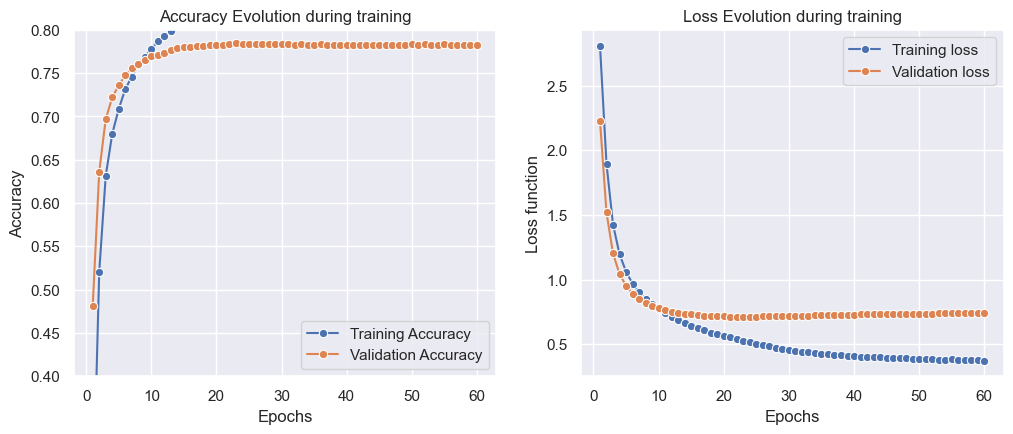

In [37]:
fm.plot_training_history(history, Nb_epochs, AccRange = [0.4,0.8], LossRange = None)

**train test accuracy**

In [19]:
loss_train, accuracy_train = image_model.evaluate(output_vector_train, yy_train)
print("\t Train loss function = %0.3f \n Train accuracy = %0.3f \n\n" %(loss_train, accuracy_train))

loss_val, accuracy_val = image_model.evaluate(output_vector_val, yy_val)
print("\t Validation loss function = %0.3f \n Validation accuracy = %0.3f \n\n" %(loss_val, accuracy_val))

loss_test, accuracy_test = image_model.evaluate(output_vector_test, yy_test)
print(" Test loss function = %0.3f \n Test accuracy = %0.3f \n\n" %(loss_test, accuracy_test))

1699/1699 [==============================] - 6s 3ms/step - loss: 0.8442 - accuracy: 0.7453
	 Train loss function = 0.844 
 Train accuracy = 0.745 


425/425 [==============================] - 1s 3ms/step - loss: 1.3764 - accuracy: 0.5918
	 Validation loss function = 1.376 
 Validation accuracy = 0.592 


531/531 [==============================] - 5s 9ms/step - loss: 1.3671 - accuracy: 0.5921
 Test loss function = 1.367 
 Test accuracy = 0.592 




**Save or Reload trained text model**

In [20]:
save = True
reload = False

if save:
    fm.save_model(image_model, name = 'image_model_trained', 
                  path = '../fm/Trained_models/image_model/', 
                  doit = True)
    

if reload:
    text_model = fm.reload_model('../fm/Trained_models/image_model/____image_model_trained.keras', 
                       path = fusion_path, 
                       doit = True)
    text_model.summary()

Model saved as ../fm/Trained_models/image_model/2309012031_image_model_trained.keras


# 3 - _Text data_

## 3.1 - Preprocess Text Data
* [x]  Do it for the three subsets: train, val, test in **sorted order**
* Clean data
* Feature engineering
* Address NaNs

In [50]:
reload = True

if reload:
    
    path = '../fm/Splitted_datasets/Images_224px/'

    df_X_train_sorted = pd.read_csv(path + '2308272257_df_X_train_sorted.csv', header = 0, index_col = 0)
    df_X_val_sorted = pd.read_csv(path + '2308272257_df_X_val_sorted.csv', header = 0, index_col = 0)
    df_X_test_sorted = pd.read_csv(path + '2308272257_df_X_test_sorted.csv', header = 0, index_col = 0)    
    
    df_y_train_sorted = pd.read_csv(path + '2308272257_df_y_train_sorted.csv', header = 0, index_col = 0)
    df_y_val_sorted = pd.read_csv(path + '2308272257_df_y_val_sorted.csv', header = 0, index_col = 0)
    df_y_test_sorted = pd.read_csv(path + '2308272257_df_y_test_sorted.csv', header = 0, index_col = 0)

In [51]:
## preprocess datasets: Data cleaning & Feature engineering

df_X_train_preprocess = fm.preprocess_text_data(df_X_train_sorted, verbose = True)
df_X_val_preprocess = fm.preprocess_text_data(df_X_val_sorted, verbose = True)
df_X_test_preprocess = fm.preprocess_text_data(df_X_test_sorted, verbose = True)


Column 'designation' has been renamed as 'title' 

Columns 'title' and 'description' have been concatenated in a new variable 'title_descr' 

Column 'title_descr' has been successfully HTML parsed and decapitalized.
	 HTML parsing takes 14.69 seconds 

Column 'title_descr' has been successfully tokenized.
	 Tokenization + Lemmatization takes 17.87 seconds 

Main language detection takes 3.02 minutes.
	 Language detection correction takes 2.65 seconds 

Removing stop-words takes 72.68 seconds. 

Token counting takes 0.02 seconds. 

Column 'designation' has been renamed as 'title' 

Columns 'title' and 'description' have been concatenated in a new variable 'title_descr' 

Column 'title_descr' has been successfully HTML parsed and decapitalized.
	 HTML parsing takes 3.37 seconds 

Column 'title_descr' has been successfully tokenized.
	 Tokenization + Lemmatization takes 4.22 seconds 

Main language detection takes 0.74 minutes.
	 Language detection correction takes 1.76 seconds 

Removing

In [53]:
check_index_order = True

if check_index_order:
    print(all(df_X_train_preprocess.index == df_X_train_sorted.index))
    print(all(df_X_val_preprocess.index == df_X_val_sorted.index))
    print(all(df_X_test_preprocess.index == df_X_test_sorted.index))

True
True
True


### Save Preprocessed datasets

In [65]:
preprocessing_path

'../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/'

In [66]:
fm.save(datasets = [df_X_train_preprocess, df_X_val_preprocess, df_X_test_preprocess], 
             types = ['dataframe']*3,
             names = ['df_X_train_preprocess', 'df_X_val_preprocess', 'df_X_test_preprocess'], 
              path = preprocessing_path, doit = True, verbose = True)


Saved dataset: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281204_df_X_train_preprocess.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281204_df_X_val_preprocess.csv
Saved dataset: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281204_df_X_test_preprocess.csv


### Load preprocessed data (Optional)
It helps to free processing memory if restarting the kernel and loading the followinf datasets.

In [69]:
reload_preprocessed_text_data = False

if reload_preprocessed_text_data:
    
    path_X = preprocessing_path
    path_y = splitting_path + 'Images_224px/'
    
    df_X_train_preprocess = pd.read_csv(path_X + '2308281204_df_X_train_preprocess.csv', header = 0, index_col = 0, sep = ',')
    df_X_val_preprocess   = pd.read_csv(path_X + '2308281204_df_X_val_preprocess.csv',   header = 0, index_col = 0, sep = ',')
    df_X_test_preprocess  = pd.read_csv(path_X + '2308281204_df_X_test_preprocess.csv',  header = 0, index_col = 0, sep = ',')
    df_y_train_sorted = pd.read_csv( path_y + '2308272257_df_y_train_sorted.csv', header = 0, index_col = 0, sep = ',')
    df_y_val_sorted   = pd.read_csv( path_y + '2308272257_df_y_val_sorted.csv',   header = 0, index_col = 0, sep = ',')
    df_y_test_sorted  = pd.read_csv( path_y + '2308272257_df_y_test_sorted.csv',  header = 0, index_col = 0, sep = ',')

    # df_X_train_preprocess.head()

## 3.2 Transform text data (vectorize)

### Transform text data
* In a format accepted by ML models: np.arrays.
* encode categeorical features
* normalize numerical features
* vectorize tokens
* encode target

In [74]:
## transform dataset to feed into model

text_data, targets, text_transformer = fm.get_text_data(df_X_train_preprocess, df_X_val_preprocess, df_X_test_preprocess, 
                                                        df_y_train_sorted, df_y_val_sorted, df_y_test_sorted)



Vectorizer Vocabulary contains : 5000 terms
First Vocabulary terms : {'guide': 2269, 'usage': 4668, 'saint': 4070, 'france': 2120, 'petits': 3407, 'time': 4505, 'piece': 3422, 'double': 1612, 'decorative': 1479, 'essai': 1853}


### Save transformed datasets, transformers and encoder objects

In [76]:

## Save transformed features:
fm.save(datasets = [text_data['X_train'], text_data['X_val'], text_data['X_test'] ], 
             types = ['sparseMatrix']*3, 
             names = ['text_data_transformed_X_train', 'text_data_transformed_X_val', 'text_data_transformed_X_test'], 
              path = preprocessing_path, doit = True, verbose = True )

## save transformed targets:
fm.save(datasets = [ targets['y_train'], targets['y_val'], targets['y_test'] ], 
             types = ['array']*3, 
             names = ['text_data_transformed_y_train', 'text_data_transformed_y_val', 'text_data_transformed_y_test'], 
              path = preprocessing_path, doit = True, verbose = True )

## save tranformers:
fm.save(datasets = [ text_transformer['X_transformer']['token_len_scaler'], 
                     text_transformer['X_transformer']['language_encoder'],
                     text_transformer['X_transformer']['lemmas_vectorizer'], 
                     text_transformer['y_transformer'] ], 
             types = ['transformer']*4, 
             names = ['token_len_scaler','language_encoder', 'lemmas_vectorizer', 'text_target_encoder'], 
              path = preprocessing_path, doit = True, verbose = True )


Saved sparseMatrix : ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_text_data_transformed_X_train.npz
Saved sparseMatrix : ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_text_data_transformed_X_val.npz
Saved sparseMatrix : ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_text_data_transformed_X_test.npz
Saved dataset: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_text_data_transformed_y_train.npy
Saved dataset: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_text_data_transformed_y_val.npy
Saved dataset: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_text_data_transformed_y_test.npy
Saved transformer: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_token_len_scaler
Saved transformer: ../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/2308281220_language_encoder
Saved transformer: ../fm/Splitted_datasets/Images_224p

### Load transformed data (Optional)
Start from here if RAM is limited

**Features**

In [21]:
from scipy import sparse

text_data = {}

path = '../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/' 

text_data['X_train'] = sparse.load_npz(path + '2308281220_text_data_transformed_X_train.npz')
text_data['X_val'] = sparse.load_npz(path + '2308281220_text_data_transformed_X_val.npz')
text_data['X_test'] = sparse.load_npz(path + '2308281220_text_data_transformed_X_test.npz')

**Targets**

In [22]:
targets = {}

# path = '../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/' 

targets['y_train'] = np.load(path + "2308281220_text_data_transformed_y_train.npy")
targets['y_val'] = np.load(path + "2308281220_text_data_transformed_y_val.npy")
targets['y_test'] = np.load(path + "2308281220_text_data_transformed_y_test.npy")

**Transformers**

In [23]:
import joblib

# token_len_scaler = joblib.load("../Preprocessed_data/2308141825_token_len_scaler")
# language_encoder = joblib.load("../Preprocessed_data/2308141825_language_encoder")
# lemmas_vectorizer = joblib.load("../Preprocessed_data/2308141825_lemmas_vectorizer")
target_encoder = joblib.load(path + "2308281220_text_target_encoder")

## 3.3 Text modeling


### Initialize text model

In [26]:
## intialize text model:

text_model = fm.initialize_text_model(model_type  = "NN", \
                             Nb_features = text_data['X_train'].shape[1], \
                             Nb_classes  = targets['y_train'].shape[1])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5035)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               1289216   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 27)                6939      
                                                                 
Total params: 1,296,155
Trainable params: 1,296,155
Non-trainable params: 0
_________________________________________________________________


None

**Compile model**

In [27]:
Nb_epochs = 60    # Nb of epoch for training
lr_0 = 0.4e-3     # Initial learning rate

text_model = fm.compile_text_model(text_model, lr_0)

**Define callback to use**

In [28]:
checkpoint_filepath = '../fm/tmp_checkpoint/text_model/'

callbacks = fm.get_callbacks(checkpoint_filepath)

### Fit text model 

In [29]:
## train model
history = text_model.fit(text_data["X_train"].toarray(), targets["y_train"],
                         validation_data = (text_data["X_val"].toarray(), targets["y_val"]), 
                         epochs = Nb_epochs,
                         batch_size = 200,
                         callbacks = callbacks)  

text_model.load_weights(checkpoint_filepath)

model_date_time = fm.date_time()
print("Model Training timestamp", model_date_time)

Epoch 1/60
270/272 [============================>.] - ETA: 0s - loss: 2.8131 - accuracy: 0.2332
Epoch 1: val_accuracy improved from -inf to 0.48075, saving model to ../fm/tmp_checkpoint/text_model\
272/272 [==============================] - 7s 22ms/step - loss: 2.8102 - accuracy: 0.2343 - val_loss: 2.2292 - val_accuracy: 0.4808 - lr: 4.0000e-04
Epoch 2/60
268/272 [============================>.] - ETA: 0s - loss: 1.8994 - accuracy: 0.5195
Epoch 2: val_accuracy improved from 0.48075 to 0.63605, saving model to ../fm/tmp_checkpoint/text_model\
272/272 [==============================] - 4s 14ms/step - loss: 1.8947 - accuracy: 0.5207 - val_loss: 1.5187 - val_accuracy: 0.6360 - lr: 4.0000e-04
Epoch 3/60
271/272 [============================>.] - ETA: 0s - loss: 1.4260 - accuracy: 0.6314
Epoch 3: val_accuracy improved from 0.63605 to 0.69699, saving model to ../fm/tmp_checkpoint/text_model\
272/272 [==============================] - 4s 15ms/step - loss: 1.4257 - accuracy: 0.6315 - val_loss: 

Epoch 25/60
272/272 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.8489
Epoch 25: val_accuracy did not improve from 0.78413
272/272 [==============================] - 4s 14ms/step - loss: 0.5029 - accuracy: 0.8489 - val_loss: 0.7138 - val_accuracy: 0.7840 - lr: 4.0000e-04
Epoch 26/60
272/272 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.8534
Epoch 26: val_accuracy did not improve from 0.78413
272/272 [==============================] - 4s 14ms/step - loss: 0.4922 - accuracy: 0.8534 - val_loss: 0.7147 - val_accuracy: 0.7837 - lr: 4.0000e-04
Epoch 27/60
269/272 [============================>.] - ETA: 0s - loss: 0.4844 - accuracy: 0.8542
Epoch 27: val_accuracy did not improve from 0.78413

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00027999999292660505.
272/272 [==============================] - 4s 14ms/step - loss: 0.4846 - accuracy: 0.8542 - val_loss: 0.7153 - val_accuracy: 0.7836 - lr: 4.0000e-04
Epoch 28/60
270/272 [======

271/272 [============================>.] - ETA: 0s - loss: 0.3869 - accuracy: 0.8818
Epoch 51: val_accuracy did not improve from 0.78413
272/272 [==============================] - 4s 16ms/step - loss: 0.3870 - accuracy: 0.8816 - val_loss: 0.7366 - val_accuracy: 0.7826 - lr: 6.7228e-05
Epoch 52/60
272/272 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8832
Epoch 52: val_accuracy did not improve from 0.78413

Epoch 52: ReduceLROnPlateau reducing learning rate to 4.7059589996933936e-05.
272/272 [==============================] - 4s 16ms/step - loss: 0.3831 - accuracy: 0.8832 - val_loss: 0.7374 - val_accuracy: 0.7831 - lr: 6.7228e-05
Epoch 53/60
270/272 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8855
Epoch 53: val_accuracy did not improve from 0.78413
272/272 [==============================] - 5s 17ms/step - loss: 0.3812 - accuracy: 0.8856 - val_loss: 0.7378 - val_accuracy: 0.7830 - lr: 4.7060e-05
Epoch 54/60
268/272 [==================

### Evaluate text model
Create a function that returns:  
* training evolution plot
* train test accuracy
* confusion matrix plot
* classification report graph

Add as options to save:
* confusion matrix
* classification report

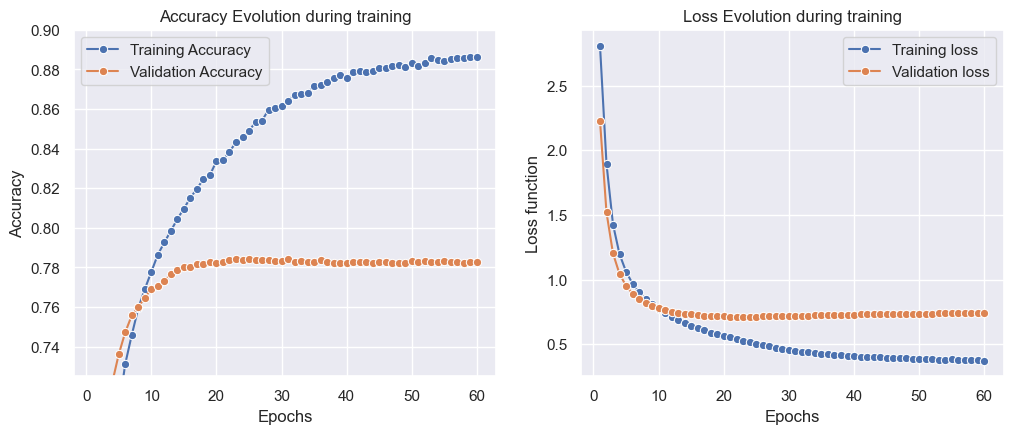

In [34]:
fm.plot_training_history(history, Nb_epochs,AccRange = [0.725,0.9], LossRange = None)

**train test accuracy**

In [31]:
loss_train, accuracy_train = text_model.evaluate(text_data["X_train"].toarray(), targets["y_train"])
print(" Train loss function = %0.3f \n Train accuracy = %0.3f \n\n" %(loss_train, accuracy_train))

loss_val, accuracy_val = text_model.evaluate(text_data["X_val"].toarray(), targets["y_val"])
print(" Validation loss function = %0.3f \n Validation accuracy = %0.3f \n\n" %(loss_val, accuracy_val))

loss_test, accuracy_test = text_model.evaluate(text_data["X_test"].toarray(), targets["y_test"])
print(" Test loss function = %0.3f \n Test accuracy = %0.3f \n\n" %(loss_test, accuracy_test))

1699/1699 [==============================] - 8s 5ms/step - loss: 0.4171 - accuracy: 0.8738
 Train loss function = 0.417 
 Train accuracy = 0.874 


425/425 [==============================] - 2s 4ms/step - loss: 0.7129 - accuracy: 0.7841
 Validation loss function = 0.713 
 Validation accuracy = 0.784 


531/531 [==============================] - 2s 4ms/step - loss: 0.7438 - accuracy: 0.7727
 Test loss function = 0.744 
 Test accuracy = 0.773 




### Save or Reload trained text model

In [35]:
save = True
reload = False

if save:
    fm.save_model(text_model, name = 'text_model_trained', 
                  path = '../fm/Trained_models/text_model/', 
                  doit = True)
    

if reload:
    text_model = fm.reload_model('../fm/Trained_models/text_model/_________text_model_trained.keras', 
                       path = fusion_path, 
                       doit = True)
    text_model.summary()

Model saved as ../fm/Trained_models/text_model/2309012047_text_model_trained.keras


# 4 - Headless models

**Get training data ready to feed**  
text_data = get_text_data()  
image_data = get_image_data()  

**Define headless models**  
image_model = initialize_image_model()  
text_model = initialize_text_model()  

headless_image_model = remove_classification_head(image_model)  
headless_text_model = remove_classification_head(text_model)  
headless_text_model.save("...")  
headless_image_model.save("...")  

**define train data for fusion model**  
headless_X_train_image = headless_image_model.predict(image_data["train"])  
headless_X_train_text = headless_text_model.predict(text_data["train"])  

X_train = concatenate(headless_X_train_text, headless_X_train_image)  

**define and train fusion model**  
fusion_model = build_fusion_model()  
fusion_model.fit(X_train)  
fusion_model.save("...")  


## 4.1 Load Transformed text & image data

### Reload text data: ready to use

**Features**

In [38]:
from scipy import sparse

text_data = {}

path = '../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/' 

text_data['X_train'] = sparse.load_npz(path + '2308281220_text_data_transformed_X_train.npz').toarray()
text_data['X_val'] = sparse.load_npz(path + '2308281220_text_data_transformed_X_val.npz').toarray()
text_data['X_test'] = sparse.load_npz(path + '2308281220_text_data_transformed_X_test.npz').toarray()

**Targets**

In [6]:
# targets = {}

# # path = '../fm/Splitted_datasets/Images_224px/Preprocessed_text_data/' 

# targets['y_train'] = np.load(path + "2308281220_text_data_transformed_y_train.npy")
# targets['y_val'] = np.load(path + "2308281220_text_data_transformed_y_val.npy")
# targets['y_test'] = np.load(path + "2308281220_text_data_transformed_y_test.npy")

**Transformers**

In [54]:
# import joblib

# # token_len_scaler = joblib.load("../Preprocessed_data/2308141825_token_len_scaler")
# # language_encoder = joblib.load("../Preprocessed_data/2308141825_language_encoder")
# # lemmas_vectorizer = joblib.load("../Preprocessed_data/2308141825_lemmas_vectorizer")
# target_encoder = joblib.load(path + "2308281220_text_target_encoder")

### Reload image data: ready to use

**Features**

In [39]:
t0 = time.time()

image_data = {}

path = '../fm/Splitted_datasets/Images_224px/'

image_data['X_train'] = np.load(path + '2308272122_hlVGG_output_vector_train.npy')
image_data['X_val'] = np.load(path + '2308272255_hlVGG_output_vector_val.npy')
image_data['X_test'] = np.load(path + '2308272255_hlVGG_output_vector_test.npy')

t1 = time.time()
print("Loading VGG extracted features takes %0.2f seconds" %(t1-t0))

Loading VGG extracted features takes 19.43 seconds


**Targets**
- [ ] it is not tranformed: it is not one hot encoded

In [ ]:
# targets = {}
# targets['y_train'] = pd.read_csv(path + '2308272257_df_y_train_sorted.csv', header = 0, index_col = 0)
# targets['y_val'] = pd.read_csv(path + '2308272257_df_y_val_sorted.csv', header = 0, index_col = 0)
# targets['y_test'] = pd.read_csv(path + '2308272257_df_y_test_sorted.csv', header = 0, index_col = 0)


**Transformers**

In [107]:
# import joblib

# # token_len_scaler = joblib.load("../Preprocessed_data/2308141825_token_len_scaler")
# # language_encoder = joblib.load("../Preprocessed_data/2308141825_language_encoder")
# # lemmas_vectorizer = joblib.load("../Preprocessed_data/2308141825_lemmas_vectorizer")
# target_encoder = joblib.load("../Preprocessed_data/2308141825_target_encoder")

## 4.2 Define headless models

### Headless text model

In [40]:
## load pretrained text model:  parent model

text_model = fm.reload_model('2309012047_text_model_trained.keras', 
                       path = '../fm/Trained_models/text_model/',
                       doit = True)

text_model.summary()

Reloaded model from ../fm/Trained_models/text_model/2309012047_text_model_trained.keras
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5035)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               1289216   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 27)                6939      
                                                                 
Total params: 1,296,155
Trainable params: 1,296,155
Non-trainable params: 0
_________________________________________________________________


In [41]:
## define the headless_model for text

headless_text_model = fm.remove_classification_head(text_model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5035)]            0         
                                                                 
 dense_1 (Dense)             (None, 256)               1289216   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
Total params: 1,289,216
Trainable params: 1,289,216
Non-trainable params: 0
_________________________________________________________________


None

In [42]:
## verify that is actually works:

# headless_text_model.summary()
y_pred_txt_hl = headless_text_model.predict(text_data['X_test'])


531/531 [==============================] - 2s 4ms/step


In [44]:
# y_pred_txt_hl.shape
print("min output value = ",  y_pred_txt_hl[:,:].min())
print("max output value = ",  y_pred_txt_hl[:,:].max())

# y_pred_txt_hl[0,:30]

min output value =  0.0
max output value =  1.325588


### Headless image model

In [45]:
## load pretrained image model:  parent model

image_model = fm.reload_model('2309012031_image_model_trained.keras',  
                       path = '../fm/Trained_models/image_model/',  
                       doit = True)

image_model.summary()

Reloaded model from ../fm/Trained_models/image_model/2309012031_image_model_trained.keras
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (

In [46]:
## define headless model for image data:

headless_image_model = fm.remove_classification_head(image_model)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1_  [(None, 7, 7, 512)]      0         
 input (InputLayer)                                              
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0   

None

In [47]:
## verify that is actually works:

# headless_image_model.summary()
y_pred_img_hl = headless_image_model.predict(image_data['X_test'])


531/531 [==============================] - 2s 3ms/step


In [48]:
# y_pred_txt_hl.shimg
print("min output value = ",  y_pred_img_hl[:,:].min())
print("max output value = ",  y_pred_img_hl[:,:].max())

# y_pred_img_hl[0,:30]

min output value =  0.0
max output value =  4.3296447


### Save text & image headless models

In [51]:
## save both headless models:

fm.save_model(headless_text_model, name = 'headless_text_model', 
              path = '../fm/Trained_models/text_model/', 
              doit = True)

fm.save_model(headless_image_model, name = 'headless_image_model', 
              path = '../fm/Trained_models/image_model/', 
              doit = True)


Model saved as ../fm/Trained_models/text_model/2309012056_headless_text_model.keras
Model saved as ../fm/Trained_models/image_model/2309012056_headless_image_model.keras


## 4.3 Define train-val-test data for fusion model

**scaled text and image data**

In [52]:
text_data_scaled = fm.get_headless_predictions_scaled(headless_text_model, text_data)

531/531 [==============================] - 2s 4ms/step


In [53]:
image_data_scaled = fm.get_headless_predictions_scaled(headless_image_model, image_data)

531/531 [==============================] - 2s 4ms/step


In [52]:
# print(text_data_scaled['X_train'].min(), text_data_scaled['X_train'].max())
# print(text_data_scaled['X_val'].min(), text_data_scaled['X_val'].max())
# print(text_data_scaled['X_test'].min(), text_data_scaled['X_test'].max())

0.0 1.0
0.0 1.115154
0.0 1.1420965


**Concatenate text and image data**

In [54]:
fusion_data = fm.get_fusion_model_dataset(text_data_scaled, image_data_scaled)

X_train
X_val
X_test


In [51]:
# print(fusion_data.keys())
# print(fusion_data['X_train'].shape)
# print(fusion_data['X_train'].min(), fusion_data['X_train'].max())
# print(fusion_data['X_val'].min(), fusion_data['X_val'].max())
# print(fusion_data['X_test'].min(), fusion_data['X_test'].max())

dict_keys(['X_train', 'X_val', 'X_test'])
(54345, 512)
0.0 1.0
0.0 1.1645077
0.0 1.236838


### Save data for fusion model

In [55]:
## save concatenated array

path = '../fm/Splitted_datasets/Images_224px/Fusion_data/'

fm.save(datasets = [fusion_data['X_train'], fusion_data['X_val'], fusion_data['X_test']], \
            types = ['array']*3, \
             names = ['fusion_data_X_train', 'fusion_data_X_val', 'fusion_data_X_test'], \
              path = path, doit = True, verbose = True)

Saved dataset: ../fm/Splitted_datasets/Images_224px/Fusion_data/2309012059_fusion_data_X_train.npy
Saved dataset: ../fm/Splitted_datasets/Images_224px/Fusion_data/2309012059_fusion_data_X_val.npy
Saved dataset: ../fm/Splitted_datasets/Images_224px/Fusion_data/2309012059_fusion_data_X_test.npy


# 5 - Fusion model 
- fusion_model = build_fusion_model()  
- fusion_model.fit(X_train)  
- fusion_model.save("...")  

### Get data for fusion model

In [56]:
path_X = '../fm/Splitted_datasets/Images_224px/Fusion_data/'

X_train = np.load( path_X + "2309012059_fusion_data_X_train.npy")
X_val   = np.load( path_X + "2309012059_fusion_data_X_val.npy")
X_test  = np.load( path_X + "2309012059_fusion_data_X_test.npy")


path_y = '../fm/Splitted_datasets/Images_224px/'

df_y_train_sorted = pd.read_csv( path_y + '2308272257_df_y_train_sorted.csv', header = 0, index_col = 0)
df_y_val_sorted   = pd.read_csv( path_y + '2308272257_df_y_val_sorted.csv', header = 0, index_col = 0)
df_y_test_sorted  = pd.read_csv( path_y + '2308272257_df_y_test_sorted.csv', header = 0, index_col = 0)

yy_train, yy_val, yy_test, target_encoder = fm.transform_target(df_y_train_sorted, df_y_val_sorted, df_y_test_sorted)


### Initialize Fusion  Model

In [65]:

fusion_model = fm.initialize_fusion_model('NN', X_train.shape[1], yy_train.shape[1])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_10 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_11 (Bat  (None, 1024)            

None

**Compile model**

In [68]:
Nb_epochs = 100    # Nb of epoch for training
lr_0 = 2.0e-6     # Initial learning rate

fusion_model = fm.compile_fusion_model(fusion_model, lr_0)

**Define callback to use**

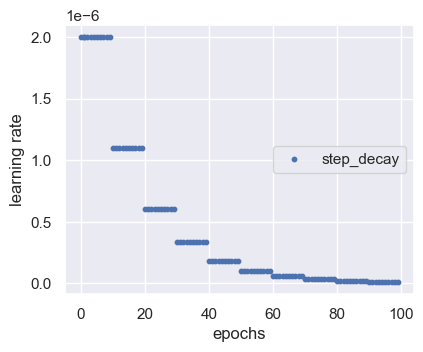

In [69]:
checkpoint_filepath = '../fm/tmp_checkpoint/fusion_model/'
# callbacks = fm.get_callbacks(checkpoint_filepath)


scheduler, schedule = fm.LR_scheduler()
fm.plot_lr_schedule(schedule, names = ['step_decay'], lr0 = lr_0, epochs = Nb_epochs)


callbacks = [
            fm.get_model_checkpoint(checkpoint_filepath),
#             scheduler[0],
            fm.get_reduceLRonPlateau()
            ]

### Fit fusion model 

* [ ] Add the callbakcs! 

In [70]:
## train model
history = fusion_model.fit(X_train, yy_train,
                           validation_data = (X_val, yy_val), 
                           epochs = Nb_epochs,
                           batch_size = 200,
                           callbacks = callbacks)  

fusion_model.load_weights(checkpoint_filepath)

model_date_time = fm.date_time()
print("Model Training timestamp", model_date_time)

Epoch 1/100
271/272 [============================>.] - ETA: 0s - loss: 4.7352 - accuracy: 0.0679
Epoch 1: val_accuracy improved from -inf to 0.18569, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 9s 29ms/step - loss: 4.7340 - accuracy: 0.0680 - val_loss: 2.9594 - val_accuracy: 0.1857 - lr: 2.0000e-06
Epoch 2/100
272/272 [==============================] - ETA: 0s - loss: 3.3309 - accuracy: 0.2110
Epoch 2: val_accuracy improved from 0.18569 to 0.49062, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 8s 28ms/step - loss: 3.3309 - accuracy: 0.2110 - val_loss: 1.9127 - val_accuracy: 0.4906 - lr: 2.0000e-06
Epoch 3/100
272/272 [==============================] - ETA: 0s - loss: 2.4862 - accuracy: 0.3649
Epoch 3: val_accuracy improved from 0.49062 to 0.60617, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 8s 28ms/step - loss: 2.4862 - accuracy: 0.3649 - v

271/272 [============================>.] - ETA: 0s - loss: 0.5188 - accuracy: 0.8463
Epoch 24: val_accuracy improved from 0.81600 to 0.81652, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 7s 27ms/step - loss: 0.5187 - accuracy: 0.8464 - val_loss: 0.6504 - val_accuracy: 0.8165 - lr: 2.0000e-06
Epoch 25/100
272/272 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.8499
Epoch 25: val_accuracy improved from 0.81652 to 0.81733, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 7s 27ms/step - loss: 0.5073 - accuracy: 0.8499 - val_loss: 0.6490 - val_accuracy: 0.8173 - lr: 2.0000e-06
Epoch 26/100
270/272 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8509
Epoch 26: val_accuracy improved from 0.81733 to 0.81769, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 7s 27ms/step - loss: 0.5006 - accuracy: 0.8509 - val_l

272/272 [==============================] - 8s 28ms/step - loss: 0.4122 - accuracy: 0.8769 - val_loss: 0.6468 - val_accuracy: 0.8233 - lr: 6.8600e-07
Epoch 48/100
271/272 [============================>.] - ETA: 0s - loss: 0.4117 - accuracy: 0.8771
Epoch 48: val_accuracy improved from 0.82329 to 0.82343, saving model to ../fm/tmp_checkpoint/fusion_model\
272/272 [==============================] - 7s 27ms/step - loss: 0.4121 - accuracy: 0.8770 - val_loss: 0.6469 - val_accuracy: 0.8234 - lr: 6.8600e-07
Epoch 49/100
270/272 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.8777
Epoch 49: val_accuracy did not improve from 0.82343
272/272 [==============================] - 7s 27ms/step - loss: 0.4096 - accuracy: 0.8776 - val_loss: 0.6469 - val_accuracy: 0.8233 - lr: 6.8600e-07
Epoch 50/100
270/272 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8777
Epoch 50: val_accuracy improved from 0.82343 to 0.82388, saving model to ../fm/tmp_checkpoint/fusio

Epoch 73/100
272/272 [==============================] - ETA: 0s - loss: 0.4044 - accuracy: 0.8787
Epoch 73: val_accuracy did not improve from 0.82446
272/272 [==============================] - 8s 28ms/step - loss: 0.4044 - accuracy: 0.8787 - val_loss: 0.6485 - val_accuracy: 0.8240 - lr: 1.1530e-07
Epoch 74/100
270/272 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.8793
Epoch 74: val_accuracy did not improve from 0.82446
272/272 [==============================] - 7s 26ms/step - loss: 0.4031 - accuracy: 0.8792 - val_loss: 0.6489 - val_accuracy: 0.8245 - lr: 1.1530e-07
Epoch 75/100
272/272 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.8815
Epoch 75: val_accuracy did not improve from 0.82446

Epoch 75: ReduceLROnPlateau reducing learning rate to 8.070721264630264e-08.
272/272 [==============================] - 8s 28ms/step - loss: 0.3997 - accuracy: 0.8815 - val_loss: 0.6479 - val_accuracy: 0.8239 - lr: 1.1530e-07
Epoch 76/100
271/272 [===

Epoch 99/100
270/272 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8810
Epoch 99: val_accuracy did not improve from 0.82491
272/272 [==============================] - 8s 28ms/step - loss: 0.3984 - accuracy: 0.8811 - val_loss: 0.6484 - val_accuracy: 0.8247 - lr: 1.9378e-08
Epoch 100/100
270/272 [============================>.] - ETA: 0s - loss: 0.3977 - accuracy: 0.8818
Epoch 100: val_accuracy did not improve from 0.82491

Epoch 100: ReduceLROnPlateau reducing learning rate to 1.356446048816906e-08.
272/272 [==============================] - 8s 28ms/step - loss: 0.3979 - accuracy: 0.8818 - val_loss: 0.6485 - val_accuracy: 0.8241 - lr: 1.9378e-08
Model Training timestamp 2309012129


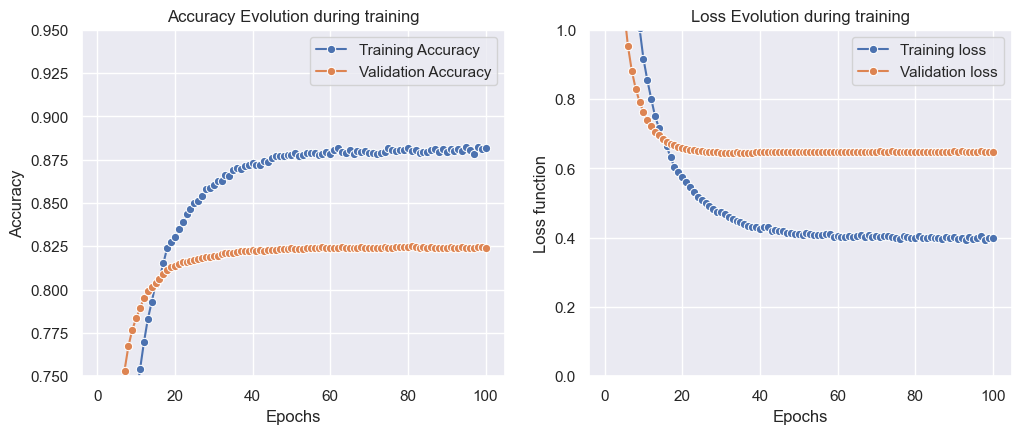

In [71]:
fm.plot_training_history(history, Nb_epochs,AccRange = [0.75,0.95], LossRange = [0,1])

**train test accuracy**

In [72]:
loss_train, accuracy_train = fusion_model.evaluate(X_train, yy_train)
print(" Train loss function = %0.3f \n Train accuracy = %0.3f \n\n" %(loss_train, accuracy_train))

loss_val, accuracy_val = fusion_model.evaluate(X_val, yy_val)
print(" Validation loss function = %0.3f \n Validation accuracy = %0.3f \n\n" %(loss_val, accuracy_val))

loss_test, accuracy_test = fusion_model.evaluate(X_test, yy_test)
print(" Test loss function = %0.3f \n Test accuracy = %0.3f \n\n" %(loss_test, accuracy_test))

1699/1699 [==============================] - 8s 5ms/step - loss: 0.2591 - accuracy: 0.9188
 Train loss function = 0.259 
 Train accuracy = 0.919 


425/425 [==============================] - 2s 4ms/step - loss: 0.6483 - accuracy: 0.8249
 Validation loss function = 0.648 
 Validation accuracy = 0.825 


531/531 [==============================] - 2s 4ms/step - loss: 0.6960 - accuracy: 0.8192
 Test loss function = 0.696 
 Test accuracy = 0.819 




### Save or Reload trained text model

In [74]:
save = True
reload = False

if save:
    fm.save_model(fusion_model, name = 'fusion_model_trained', 
                  path = '../fm/Trained_models/fusion_model/', 
                  doit = True)
    

if reload:
    text_model = fm.reload_model('_________fusion_model_trained.keras', 
                       path = '../fm/Trained_models/fusion_model/', 
                       doit = True)
    text_model.summary()

Model saved as ../fm/Trained_models/fusion_model/2309012136_fusion_model_trained.keras


**Predictions**

In [75]:
t0 = time.time()
yy_pred_vectors = fusion_model.predict(X_test)
t1 = time.time()
print("Predictions made on %0.2f seconds" %(t1-t0))


531/531 [==============================] - 2s 4ms/step
Predictions made on 2.72 seconds


**Confussion Matrix**

In [76]:
cm = fm.get_confusionMatrix(yy_test, yy_pred_vectors, 
                       target_encoder, product_class['prdtypecode'])

(27, 27)


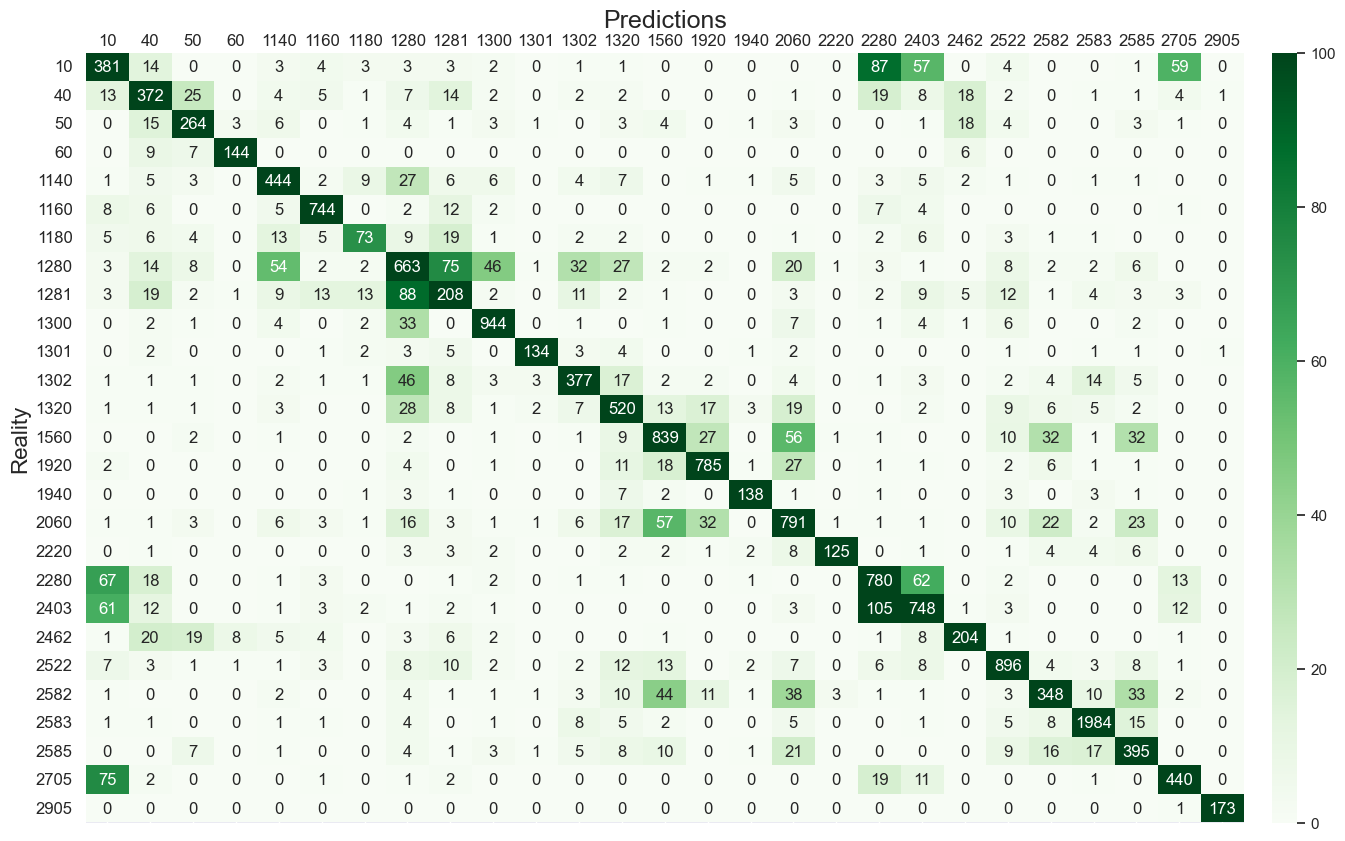

In [111]:
fm.plot_confusionMatrix(cm)

**Save confusion matrix**

In [78]:
export = True

if export:
    path = '../fm/Trained_models/fusion_model/'
    filename = path + model_date_time + '_fusion_model' + '_confusionMatrix.csv'
    
    cm.to_csv(filename, header = True, index = True)
    print(filename)

../fm/Trained_models/fusion_model/2309012129_fusion_model_confusionMatrix.csv


**Classification Report: macro & micro**

In [79]:
cr, micro_cr, macro_cr = fm.get_classificationReport(yy_test, yy_pred_vectors,
                                                     target_encoder, product_class['prdtypecode'])

In [119]:
## class labels
import Text_preprocessing_tools as tpp
importlib.reload(tpp)

product_class = pd.read_csv('../datasets/product_class.csv', sep = ';').drop('target', axis = 1)
ticks = product_class['prdtypecode']

product_class['prdtypecode'].astype(str)
tpp.concat_class_code(product_class)

classes = product_class['class_code']

ticks
# classes

0       10
1       40
2       50
3       60
4     1140
5     1160
6     1180
7     1280
8     1281
9     1300
10    1301
11    1302
12    1320
13    1560
14    1920
15    1940
16    2060
17    2220
18    2280
19    2403
20    2462
21    2522
22    2582
23    2583
24    2585
25    2705
26    2905
Name: prdtypecode, dtype: int64

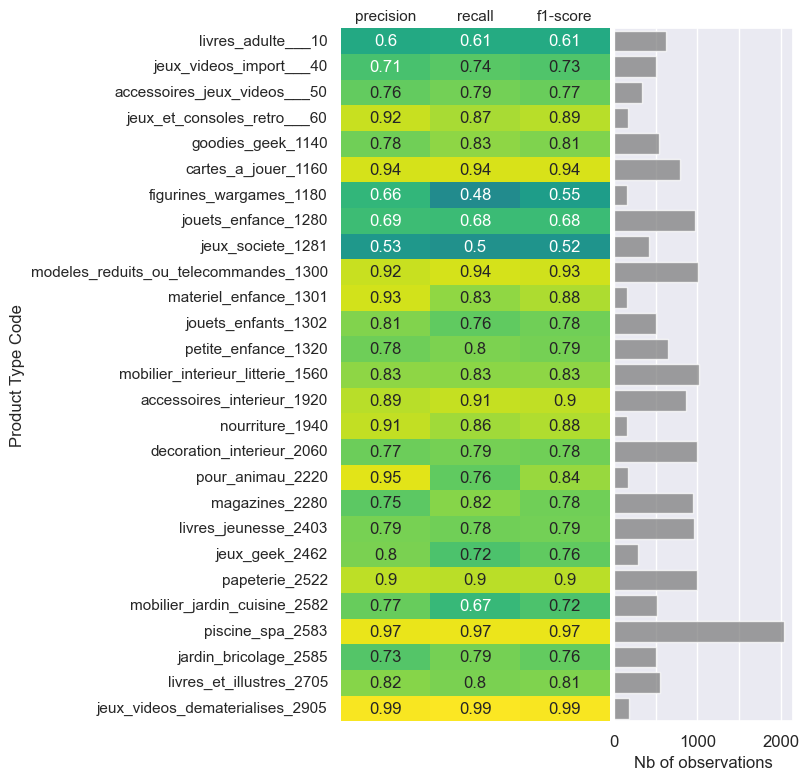

In [122]:
# fm.plot_classificationReport(micro_cr)
fm.plot_classificationReport_cl(micro_cr, classes = classes, ticks = ticks)

**Top Classified Categories**

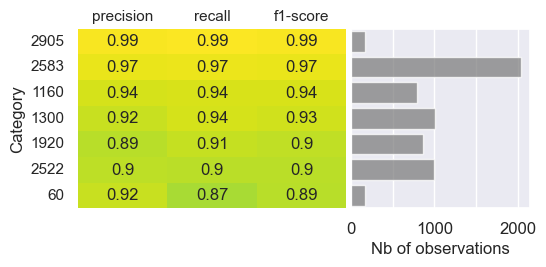

In [113]:
micro_best = micro_cr.sort_values(by = 'f1-score', ascending=False).head(7)
fm.plot_classificationReport_extract(micro_best, nb_classes = 27, nb_2show = len(micro_best))

**Worst Classified Categories**

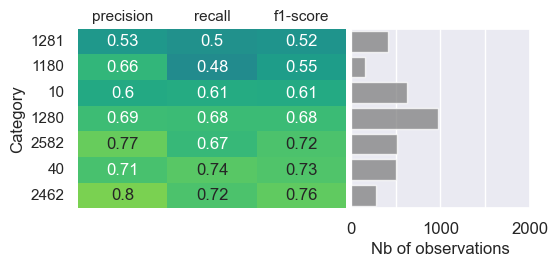

In [88]:
micro_worst = micro_cr.sort_values(by = 'f1-score', ascending=True).head(7)
fm.plot_classificationReport_extract(micro_worst, nb_classes = 27, nb_2show = len(micro_best))

**Save Classification Report**

In [90]:
export = True
path = '../fm/Trained_models/fusion_model/'
if export:
    fm.save_model_metrics(cr, metric_type = 'classificationReport_txt', 
                                   model_name = 'fusion_model', 
                                   path = path , 
                                   timestamp = model_date_time )

    fm.save_model_metrics(micro_cr, metric_type = 'classificationReport_df', 
                                   model_name = 'fusion_model', 
                                   path = path , 
                                   timestamp = model_date_time )

    fm.save_model_metrics(macro_cr, metric_type = 'classificationReport_df', 
                                   model_name = 'fusion_model', 
                                   path = path , 
                                   timestamp = model_date_time )

../fm/Trained_models/fusion_model/2309012129_fusion_model_classificationReport.txt
../fm/Trained_models/fusion_model/2309012129_fusion_model_classificationReport.csv
../fm/Trained_models/fusion_model/2309012129_fusion_model_classificationReport.csv


**Loop some parameters to get the best**

In [212]:
results = fm.hyperparam_optimization_fusion_model(Nb_epochs = 50, lr_0, X_train, yy_train, X_val, yy_val, X_test, yy_test)

Model parameters : 1024 512 0.25 0.25 0.5
 exists!
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_180 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dense_0 (Dense)             (None, 2048)              1050624   
                                                                 
 batch_normalization_181 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dropout_125 (Dropout)       (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 b


Epoch 14: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 14/50
272/272 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.9147
Epoch 14: val_accuracy improved from 0.78376 to 0.78479, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 75ms/step - loss: 0.3495 - accuracy: 0.9147 - val_loss: 0.7765 - val_accuracy: 0.7848 - lr: 1.1000e-06

Epoch 15: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 15/50
272/272 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.9181
Epoch 15: val_accuracy improved from 0.78479 to 0.78605, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 75ms/step - loss: 0.3313 - accuracy: 0.9181 - val_loss: 0.7714 - val_accuracy: 0.7860 - lr: 1.1000e-06

Epoch 16: LearningRateScheduler setting learning rate to 1.09999996

                                                                 
 dropout_129 (Dropout)       (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_187 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_130 (Dropout)       (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 27)                13851     
                                                                 
Total params: 3,703,835
Trainable params: 3,695,643
Non-trainable params: 8,192
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 1.999

272/272 [==============================] - 20s 75ms/step - loss: 0.3971 - accuracy: 0.9009 - val_loss: 0.7792 - val_accuracy: 0.7823 - lr: 1.1000e-06

Epoch 17: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 17/50
272/272 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.9077
Epoch 17: val_accuracy improved from 0.78229 to 0.78354, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 75ms/step - loss: 0.3763 - accuracy: 0.9077 - val_loss: 0.7737 - val_accuracy: 0.7835 - lr: 1.1000e-06

Epoch 18: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 18/50
272/272 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.9092
Epoch 18: val_accuracy improved from 0.78354 to 0.78413, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 21s 77ms/step - loss: 0.3

                                                                 
 dense_3 (Dense)             (None, 27)                13851     
                                                                 
Total params: 3,703,835
Trainable params: 3,695,643
Non-trainable params: 8,192
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 3.6934 - accuracy: 0.1001
Epoch 1: val_accuracy improved from -inf to 0.21270, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 23s 76ms/step - loss: 3.6934 - accuracy: 0.1001 - val_loss: 2.9334 - val_accuracy: 0.2127 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 2.7185 - accuracy: 0.2638
Epoch 2: val_accura


Epoch 18: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 18/50
272/272 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8914
Epoch 18: val_accuracy improved from 0.78178 to 0.78222, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 74ms/step - loss: 0.4301 - accuracy: 0.8914 - val_loss: 0.7779 - val_accuracy: 0.7822 - lr: 1.1000e-06

Epoch 19: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 19/50
272/272 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8969
Epoch 19: val_accuracy improved from 0.78222 to 0.78369, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 74ms/step - loss: 0.4132 - accuracy: 0.8969 - val_loss: 0.7708 - val_accuracy: 0.7837 - lr: 1.1000e-06

Epoch 20: LearningRateScheduler setting learning rate to 1.09999996

Epoch 37/50
272/272 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.9288
Epoch 37: val_accuracy improved from 0.78870 to 0.78928, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 75ms/step - loss: 0.2809 - accuracy: 0.9288 - val_loss: 0.7447 - val_accuracy: 0.7893 - lr: 3.3275e-07

Epoch 38: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 38/50
272/272 [==============================] - ETA: 0s - loss: 0.2785 - accuracy: 0.9292
Epoch 38: val_accuracy did not improve from 0.78928
272/272 [==============================] - 20s 73ms/step - loss: 0.2785 - accuracy: 0.9292 - val_loss: 0.7456 - val_accuracy: 0.7890 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
272/272 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.9264
Epoch 39: val_accuracy did not improve from 0.78928
272/

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 3.9585 - accuracy: 0.0679
Epoch 1: val_accuracy improved from -inf to 0.14190, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 22s 74ms/step - loss: 3.9585 - accuracy: 0.0679 - val_loss: 3.0589 - val_accuracy: 0.1419 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 3.2438 - accuracy: 0.1620
Epoch 2: val_accuracy improved from 0.14190 to 0.46655, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 72ms/step - loss: 3.2438 - accuracy: 0.1620 - val_loss: 2.2793 - val_accuracy: 0.4665 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 2.7014 


Epoch 19: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 19/50
272/272 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.8195
Epoch 19: val_accuracy improved from 0.76551 to 0.76684, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 72ms/step - loss: 0.7011 - accuracy: 0.8195 - val_loss: 0.8712 - val_accuracy: 0.7668 - lr: 1.1000e-06

Epoch 20: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 20/50
272/272 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.8246
Epoch 20: val_accuracy improved from 0.76684 to 0.76823, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 72ms/step - loss: 0.6728 - accuracy: 0.8246 - val_loss: 0.8584 - val_accuracy: 0.7682 - lr: 1.1000e-06

Epoch 21: LearningRateScheduler setting learning rate to 6.04999979

Epoch 37/50
272/272 [==============================] - ETA: 0s - loss: 0.4987 - accuracy: 0.8733
Epoch 37: val_accuracy improved from 0.77979 to 0.77994, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 72ms/step - loss: 0.4987 - accuracy: 0.8733 - val_loss: 0.7881 - val_accuracy: 0.7799 - lr: 3.3275e-07

Epoch 38: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 38/50
272/272 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.8742
Epoch 38: val_accuracy improved from 0.77994 to 0.78016, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 20s 72ms/step - loss: 0.4903 - accuracy: 0.8742 - val_loss: 0.7865 - val_accuracy: 0.7802 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
272/272 [==============================] - ETA: 0s - los

                                                                 
Total params: 3,703,835
Trainable params: 3,695,643
Non-trainable params: 8,192
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 3.8814 - accuracy: 0.0830
Epoch 1: val_accuracy improved from -inf to 0.17568, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 23s 72ms/step - loss: 3.8814 - accuracy: 0.0830 - val_loss: 2.9551 - val_accuracy: 0.1757 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 2.7110 - accuracy: 0.2674
Epoch 2: val_accuracy improved from 0.17568 to 0.54236, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [======

Epoch 18/50
272/272 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.9093
Epoch 18: val_accuracy improved from 0.78244 to 0.78303, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 71ms/step - loss: 0.3672 - accuracy: 0.9093 - val_loss: 0.7714 - val_accuracy: 0.7830 - lr: 1.1000e-06

Epoch 19: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 19/50
272/272 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.9123
Epoch 19: val_accuracy did not improve from 0.78303
272/272 [==============================] - 19s 70ms/step - loss: 0.3491 - accuracy: 0.9123 - val_loss: 0.7680 - val_accuracy: 0.7830 - lr: 1.1000e-06

Epoch 20: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 20/50
272/272 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.9148
Epoch 20: val_accuracy improved from 0.78303 to 0.78457,


Epoch 37: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 37/50
272/272 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.9378
Epoch 37: val_accuracy improved from 0.78928 to 0.78958, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 70ms/step - loss: 0.2421 - accuracy: 0.9378 - val_loss: 0.7571 - val_accuracy: 0.7896 - lr: 3.3275e-07

Epoch 38: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 38/50
272/272 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9388
Epoch 38: val_accuracy did not improve from 0.78958
272/272 [==============================] - 19s 70ms/step - loss: 0.2348 - accuracy: 0.9388 - val_loss: 0.7582 - val_accuracy: 0.7893 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
272/272 [==============================] - ETA: 0s - loss: 


Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 2.7682 - accuracy: 0.2539
Epoch 2: val_accuracy improved from 0.29778 to 0.57739, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 70ms/step - loss: 2.7682 - accuracy: 0.2539 - val_loss: 1.8491 - val_accuracy: 0.5774 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 2.1283 - accuracy: 0.4140
Epoch 3: val_accuracy improved from 0.57739 to 0.64944, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 70ms/step - loss: 2.1283 - accuracy: 0.4140 - val_loss: 1.4834 - val_accuracy: 0.6494 - lr: 2.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1.999999994950485

272/272 [==============================] - 19s 69ms/step - loss: 0.4282 - accuracy: 0.8914 - val_loss: 0.7779 - val_accuracy: 0.7797 - lr: 1.1000e-06

Epoch 20: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 20/50
272/272 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.8962
Epoch 20: val_accuracy improved from 0.77972 to 0.78038, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 68ms/step - loss: 0.4082 - accuracy: 0.8962 - val_loss: 0.7738 - val_accuracy: 0.7804 - lr: 1.1000e-06

Epoch 21: LearningRateScheduler setting learning rate to 6.049999797141937e-07.
Epoch 21/50
272/272 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8981
Epoch 21: val_accuracy improved from 0.78038 to 0.78053, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 68ms/step - loss: 0.39

272/272 [==============================] - 18s 68ms/step - loss: 0.2955 - accuracy: 0.9244 - val_loss: 0.7537 - val_accuracy: 0.7883 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
272/272 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9256
Epoch 39: val_accuracy did not improve from 0.78825
272/272 [==============================] - 18s 67ms/step - loss: 0.2889 - accuracy: 0.9256 - val_loss: 0.7546 - val_accuracy: 0.7882 - lr: 3.3275e-07

Epoch 40: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 40/50
271/272 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.9272
Epoch 40: val_accuracy improved from 0.78825 to 0.78840, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 68ms/step - loss: 0.2850 - accuracy: 0.9272 - val_loss: 0.7541 - val_accuracy: 0.7884 - lr: 3.3275e-07

Ep

272/272 [==============================] - 18s 68ms/step - loss: 3.1539 - accuracy: 0.1716 - val_loss: 2.1572 - val_accuracy: 0.4799 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 3/50
271/272 [============================>.] - ETA: 0s - loss: 2.4955 - accuracy: 0.3098
Epoch 3: val_accuracy improved from 0.47987 to 0.60065, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 67ms/step - loss: 2.4938 - accuracy: 0.3102 - val_loss: 1.7107 - val_accuracy: 0.6006 - lr: 2.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 2.0311 - accuracy: 0.4307
Epoch 4: val_accuracy improved from 0.60065 to 0.65739, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 67ms/step - loss: 2.0311 - 

Epoch 39/50
272/272 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.9095
Epoch 39: val_accuracy did not improve from 0.78634
272/272 [==============================] - 18s 66ms/step - loss: 0.3517 - accuracy: 0.9095 - val_loss: 0.7438 - val_accuracy: 0.7862 - lr: 3.3275e-07

Epoch 40: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 40/50
272/272 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.9085
Epoch 40: val_accuracy did not improve from 0.78634
272/272 [==============================] - 18s 66ms/step - loss: 0.3519 - accuracy: 0.9085 - val_loss: 0.7441 - val_accuracy: 0.7859 - lr: 3.3275e-07

Epoch 41: LearningRateScheduler setting learning rate to 1.830124872981287e-07.
Epoch 41/50
272/272 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.9104
Epoch 41: val_accuracy did not improve from 0.78634
272/272 [==============================] - 18s 66ms/step - loss: 0.3518 - accuracy: 0.9104

Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 2.9610 - accuracy: 0.2122
Epoch 3: val_accuracy improved from 0.41797 to 0.55987, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 65ms/step - loss: 2.9610 - accuracy: 0.2122 - val_loss: 2.0301 - val_accuracy: 0.5599 - lr: 2.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 2.5672 - accuracy: 0.2958
Epoch 4: val_accuracy improved from 0.55987 to 0.61581, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 65ms/step - loss: 2.5672 - accuracy: 0.2958 - val_loss: 1.7740 - val_accuracy: 0.6158 - lr: 2.0000e-06

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 5/50
272/272 [==============================] - ETA: 0s - loss: 2.23


Epoch 21: LearningRateScheduler setting learning rate to 6.049999797141937e-07.
Epoch 21/50
271/272 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.7796
Epoch 21: val_accuracy improved from 0.76566 to 0.76684, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 65ms/step - loss: 0.8245 - accuracy: 0.7796 - val_loss: 0.8927 - val_accuracy: 0.7668 - lr: 6.0500e-07

Epoch 22: LearningRateScheduler setting learning rate to 6.049999683455098e-07.
Epoch 22/50
272/272 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.7864
Epoch 22: val_accuracy improved from 0.76684 to 0.76742, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 66ms/step - loss: 0.8041 - accuracy: 0.7864 - val_loss: 0.8857 - val_accuracy: 0.7674 - lr: 6.0500e-07

Epoch 23: LearningRateScheduler setting learning rate to 6.0499996834

Epoch 39/50
272/272 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.8410
Epoch 39: val_accuracy improved from 0.77729 to 0.77743, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 66ms/step - loss: 0.6147 - accuracy: 0.8410 - val_loss: 0.8132 - val_accuracy: 0.7774 - lr: 3.3275e-07

Epoch 40: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 40/50
272/272 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.8409
Epoch 40: val_accuracy improved from 0.77743 to 0.77817, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 66ms/step - loss: 0.6128 - accuracy: 0.8409 - val_loss: 0.8111 - val_accuracy: 0.7782 - lr: 3.3275e-07

Epoch 41: LearningRateScheduler setting learning rate to 1.830124872981287e-07.
Epoch 41/50
271/272 [============================>.] - ETA: 0s - loss

272/272 [==============================] - 18s 65ms/step - loss: 2.7545 - accuracy: 0.2538 - val_loss: 1.8723 - val_accuracy: 0.5608 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 2.1206 - accuracy: 0.4072
Epoch 3: val_accuracy improved from 0.56083 to 0.64135, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 65ms/step - loss: 2.1206 - accuracy: 0.4072 - val_loss: 1.4973 - val_accuracy: 0.6413 - lr: 2.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 4/50
271/272 [============================>.] - ETA: 0s - loss: 1.7015 - accuracy: 0.5247
Epoch 4: val_accuracy improved from 0.64135 to 0.68006, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 65ms/step - loss: 1.7007 - 


Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
272/272 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.9286
Epoch 39: val_accuracy improved from 0.79179 to 0.79223, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 66ms/step - loss: 0.2784 - accuracy: 0.9286 - val_loss: 0.7473 - val_accuracy: 0.7922 - lr: 3.3275e-07

Epoch 40: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 40/50
271/272 [============================>.] - ETA: 0s - loss: 0.2739 - accuracy: 0.9298
Epoch 40: val_accuracy improved from 0.79223 to 0.79230, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 18s 66ms/step - loss: 0.2737 - accuracy: 0.9299 - val_loss: 0.7469 - val_accuracy: 0.7923 - lr: 3.3275e-07

Epoch 41: LearningRateScheduler setting learning rate to 1.83012487


Epoch 3: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 2.4892 - accuracy: 0.3096
Epoch 3: val_accuracy improved from 0.50887 to 0.63060, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 64ms/step - loss: 2.4892 - accuracy: 0.3096 - val_loss: 1.6883 - val_accuracy: 0.6306 - lr: 2.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 2.0342 - accuracy: 0.4293
Epoch 4: val_accuracy improved from 0.63060 to 0.68095, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 64ms/step - loss: 2.0342 - accuracy: 0.4293 - val_loss: 1.4407 - val_accuracy: 0.6809 - lr: 2.0000e-06

Epoch 5: LearningRateScheduler setting learning rate to 1.999999994950485

272/272 [==============================] - 17s 64ms/step - loss: 0.5124 - accuracy: 0.8655 - val_loss: 0.7862 - val_accuracy: 0.7766 - lr: 1.1000e-06

Epoch 21: LearningRateScheduler setting learning rate to 6.049999797141937e-07.
Epoch 21/50
272/272 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8739
Epoch 21: val_accuracy improved from 0.77655 to 0.77810, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 64ms/step - loss: 0.4901 - accuracy: 0.8739 - val_loss: 0.7816 - val_accuracy: 0.7781 - lr: 6.0500e-07

Epoch 22: LearningRateScheduler setting learning rate to 6.049999683455098e-07.
Epoch 22/50
271/272 [============================>.] - ETA: 0s - loss: 0.4772 - accuracy: 0.8769
Epoch 22: val_accuracy did not improve from 0.77810
272/272 [==============================] - 17s 63ms/step - loss: 0.4771 - accuracy: 0.8770 - val_loss: 0.7785 - val_accuracy: 0.7776 - lr: 6.0500e-07

Epoc

272/272 [==============================] - 17s 64ms/step - loss: 0.3623 - accuracy: 0.9067 - val_loss: 0.7539 - val_accuracy: 0.7844 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
271/272 [============================>.] - ETA: 0s - loss: 0.3593 - accuracy: 0.9070
Epoch 39: val_accuracy improved from 0.78435 to 0.78457, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 64ms/step - loss: 0.3595 - accuracy: 0.9069 - val_loss: 0.7529 - val_accuracy: 0.7846 - lr: 3.3275e-07

Epoch 40: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 40/50
272/272 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.9061
Epoch 40: val_accuracy improved from 0.78457 to 0.78494, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 64ms/step - loss: 0.3


Epoch 20: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 20/50
271/272 [============================>.] - ETA: 0s - loss: 0.6179 - accuracy: 0.8392
Epoch 20: val_accuracy improved from 0.77022 to 0.77184, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 63ms/step - loss: 0.6177 - accuracy: 0.8393 - val_loss: 0.8310 - val_accuracy: 0.7718 - lr: 1.1000e-06

Epoch 21: LearningRateScheduler setting learning rate to 6.049999797141937e-07.
Epoch 21/50
271/272 [============================>.] - ETA: 0s - loss: 0.5968 - accuracy: 0.8440
Epoch 21: val_accuracy did not improve from 0.77184
272/272 [==============================] - 17s 62ms/step - loss: 0.5967 - accuracy: 0.8442 - val_loss: 0.8261 - val_accuracy: 0.7718 - lr: 6.0500e-07

Epoch 22: LearningRateScheduler setting learning rate to 6.049999683455098e-07.
Epoch 22/50
272/272 [==============================] - ETA: 0s - loss: 0.

Epoch 38/50
272/272 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8839
Epoch 38: val_accuracy did not improve from 0.78148
272/272 [==============================] - 17s 63ms/step - loss: 0.4418 - accuracy: 0.8839 - val_loss: 0.7783 - val_accuracy: 0.7813 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 39/50
271/272 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.8856
Epoch 39: val_accuracy improved from 0.78148 to 0.78200, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 64ms/step - loss: 0.4356 - accuracy: 0.8855 - val_loss: 0.7773 - val_accuracy: 0.7820 - lr: 3.3275e-07

Epoch 40: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 40/50
272/272 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.8883
Epoch 40: val_accuracy improved from 0.78200 to 0.78244,

272/272 [==============================] - 20s 65ms/step - loss: 4.2804 - accuracy: 0.0482 - val_loss: 3.2308 - val_accuracy: 0.1404 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/50
271/272 [============================>.] - ETA: 0s - loss: 3.7675 - accuracy: 0.0880
Epoch 2: val_accuracy improved from 0.14043 to 0.26400, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 19s 68ms/step - loss: 3.7670 - accuracy: 0.0880 - val_loss: 2.6964 - val_accuracy: 0.2640 - lr: 2.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 3/50
271/272 [============================>.] - ETA: 0s - loss: 3.3117 - accuracy: 0.1468
Epoch 3: val_accuracy improved from 0.26400 to 0.42254, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 63ms/step - loss: 3.3116 - 


Epoch 37: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 37/50
271/272 [============================>.] - ETA: 0s - loss: 0.7766 - accuracy: 0.7934
Epoch 37: val_accuracy improved from 0.75734 to 0.75764, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 63ms/step - loss: 0.7765 - accuracy: 0.7935 - val_loss: 0.8900 - val_accuracy: 0.7576 - lr: 3.3275e-07

Epoch 38: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 38/50
271/272 [============================>.] - ETA: 0s - loss: 0.7679 - accuracy: 0.7935
Epoch 38: val_accuracy improved from 0.75764 to 0.75852, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 63ms/step - loss: 0.7678 - accuracy: 0.7935 - val_loss: 0.8854 - val_accuracy: 0.7585 - lr: 3.3275e-07

Epoch 39: LearningRateScheduler setting learning rate to 3.32749976

                                                                 
 dense_3 (Dense)             (None, 27)                13851     
                                                                 
Total params: 3,703,835
Trainable params: 3,695,643
Non-trainable params: 8,192
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 1/50
271/272 [============================>.] - ETA: 0s - loss: 4.1374 - accuracy: 0.0549
Epoch 1: val_accuracy improved from -inf to 0.11224, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 21s 67ms/step - loss: 4.1363 - accuracy: 0.0551 - val_loss: 3.1157 - val_accuracy: 0.1122 - lr: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 2/50
271/272 [============================>.] - ETA: 0s - loss: 3.4532 - accuracy: 0.1314
Epoch 2: val_accura


Epoch 18: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 18/50
271/272 [============================>.] - ETA: 0s - loss: 0.7779 - accuracy: 0.7915
Epoch 18: val_accuracy improved from 0.74969 to 0.75270, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 60ms/step - loss: 0.7775 - accuracy: 0.7916 - val_loss: 0.8824 - val_accuracy: 0.7527 - lr: 1.1000e-06

Epoch 19: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 19/50
271/272 [============================>.] - ETA: 0s - loss: 0.7382 - accuracy: 0.8034
Epoch 19: val_accuracy improved from 0.75270 to 0.75609, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 60ms/step - loss: 0.7384 - accuracy: 0.8034 - val_loss: 0.8682 - val_accuracy: 0.7561 - lr: 1.1000e-06

Epoch 20: LearningRateScheduler setting learning rate to 1.09999996


Epoch 36: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 36/50
271/272 [============================>.] - ETA: 0s - loss: 0.5199 - accuracy: 0.8606
Epoch 36: val_accuracy improved from 0.77125 to 0.77236, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 17s 61ms/step - loss: 0.5197 - accuracy: 0.8607 - val_loss: 0.7922 - val_accuracy: 0.7724 - lr: 3.3275e-07

Epoch 37: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 37/50
271/272 [============================>.] - ETA: 0s - loss: 0.5118 - accuracy: 0.8650
Epoch 37: val_accuracy improved from 0.77236 to 0.77265, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 60ms/step - loss: 0.5119 - accuracy: 0.8649 - val_loss: 0.7908 - val_accuracy: 0.7727 - lr: 3.3275e-07

Epoch 38: LearningRateScheduler setting learning rate to 3.32749976

 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_235 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_166 (Dropout)       (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 27)                13851     
                                                                 
Total params: 3,703,835
Trainable params: 3,695,643
Non-trainable params: 8,192
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999949504854e-06.
Epoch 1/50
271/272 [============================>.] - ETA: 0s - loss: 4.0283 - accuracy: 0.0627
Epoch 1: val_accuracy improved from -inf to 0.20483, saving model to ../fm/tmp_chec


Epoch 17: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 17/50
271/272 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.7335
Epoch 17: val_accuracy improved from 0.75086 to 0.75315, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 59ms/step - loss: 0.9871 - accuracy: 0.7335 - val_loss: 0.9591 - val_accuracy: 0.7531 - lr: 1.1000e-06

Epoch 18: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 18/50
272/272 [==============================] - ETA: 0s - loss: 0.9509 - accuracy: 0.7434
Epoch 18: val_accuracy improved from 0.75315 to 0.75550, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 60ms/step - loss: 0.9509 - accuracy: 0.7434 - val_loss: 0.9399 - val_accuracy: 0.7555 - lr: 1.1000e-06

Epoch 19: LearningRateScheduler setting learning rate to 1.09999996


Epoch 35: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 35/50
271/272 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.8209
Epoch 35: val_accuracy improved from 0.77140 to 0.77155, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 60ms/step - loss: 0.6689 - accuracy: 0.8210 - val_loss: 0.8243 - val_accuracy: 0.7715 - lr: 3.3275e-07

Epoch 36: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 36/50
271/272 [============================>.] - ETA: 0s - loss: 0.6575 - accuracy: 0.8231
Epoch 36: val_accuracy improved from 0.77155 to 0.77199, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 59ms/step - loss: 0.6574 - accuracy: 0.8231 - val_loss: 0.8221 - val_accuracy: 0.7720 - lr: 3.3275e-07

Epoch 37: LearningRateScheduler setting learning rate to 3.32749976

 tchNormalization)                                               
                                                                 
 dropout_168 (Dropout)       (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_239 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_169 (Dropout)       (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 27)                13851     
                                                                 
Total params: 3,703,835
Trainable params: 3,695,643
Non-trainable params: 8,192
______________________________________________________________


Epoch 34: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 34/50
271/272 [============================>.] - ETA: 0s - loss: 0.7937 - accuracy: 0.7853
Epoch 34: val_accuracy improved from 0.75572 to 0.75800, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 59ms/step - loss: 0.7937 - accuracy: 0.7853 - val_loss: 0.8804 - val_accuracy: 0.7580 - lr: 3.3275e-07

Epoch 35: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 35/50
271/272 [============================>.] - ETA: 0s - loss: 0.7890 - accuracy: 0.7857
Epoch 35: val_accuracy did not improve from 0.75800
272/272 [==============================] - 16s 58ms/step - loss: 0.7893 - accuracy: 0.7855 - val_loss: 0.8775 - val_accuracy: 0.7578 - lr: 3.3275e-07

Epoch 36: LearningRateScheduler setting learning rate to 3.3274997690568853e-07.
Epoch 36/50
271/272 [============================>.] - ETA: 0s - loss: 

                                                                 
 dropout_170 (Dropout)       (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_242 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_171 (Dropout)       (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_243 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_1

272/272 [==============================] - 16s 57ms/step - loss: 1.8432 - accuracy: 0.4882 - val_loss: 1.4108 - val_accuracy: 0.6840 - lr: 1.1000e-06

Epoch 16: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 16/50
271/272 [============================>.] - ETA: 0s - loss: 1.7922 - accuracy: 0.4994
Epoch 16: val_accuracy improved from 0.68404 to 0.68875, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 58ms/step - loss: 1.7920 - accuracy: 0.4995 - val_loss: 1.3748 - val_accuracy: 0.6887 - lr: 1.1000e-06

Epoch 17: LearningRateScheduler setting learning rate to 1.0999999631167157e-06.
Epoch 17/50
271/272 [============================>.] - ETA: 0s - loss: 1.7297 - accuracy: 0.5165
Epoch 17: val_accuracy improved from 0.68875 to 0.69449, saving model to ../fm/tmp_checkpoint/fusion_model/optimization/params_1024_512\
272/272 [==============================] - 16s 57ms/step - loss: 1.7

In [243]:
d0_units = [ item[0] for item in results['param_trained']]
d1_units = [ item[1] for item in results['param_trained']]
d2_units = [ item[2] for item in results['param_trained']]
drop0 = [ item[3] for item in results['param_trained']]
drop1 = [ item[4] for item in results['param_trained']]
drop2 = [ item[5] for item in results['param_trained']]

accuracy_train = results['accuracy_train']
accuracy_test = results['accuracy_test']


In [244]:
best_train_acc = []
best_val_acc = []

for i in range(len(training_history)):
    train_acc_hist = training_history[i].history['accuracy']
    val_acc_hist = training_history[i].history['val_accuracy']
    train_loss_hist = training_history[i].history['loss']
    val_loss_hist = training_history[i].history['val_loss']
    
    best_train_acc.append(max(train_acc_hist))
    best_val_acc.append(max(val_acc_hist))

Text(0, 0.5, 'Accuracy')

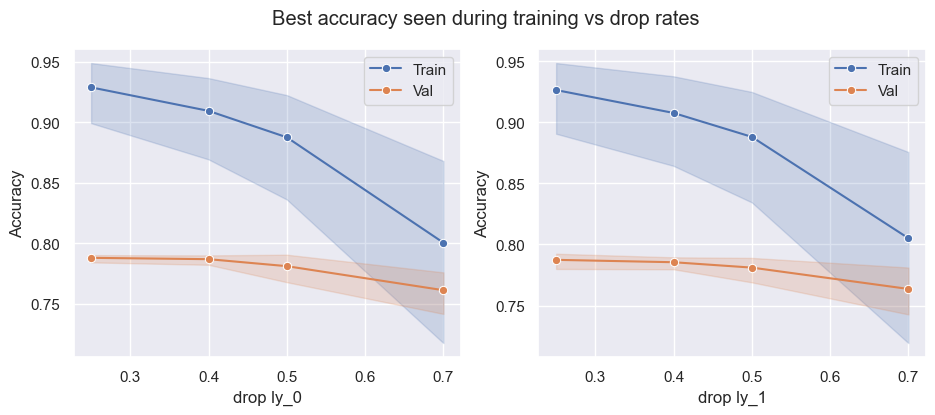

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1,2,figsize=(11,4))
fig.suptitle("Best accuracy seen during training vs drop rates")

ax = axs[0]
sns.lineplot(x = drop0, y = best_train_acc, marker = 'o', ax=ax, label = 'Train')
sns.lineplot(x = drop0, y = best_val_acc, marker = 'o', ax=ax, label = 'Val')
ax.set_xlabel("drop ly_0")
ax.set_ylabel("Accuracy")
# ax.set_ylim(0.7,0.8)
ax.legend()

ax = axs[1]
sns.lineplot(x = drop1, y = best_train_acc, marker = 'o', ax=ax, label = 'Train')
sns.lineplot(x = drop1, y = best_val_acc, marker = 'o', ax=ax, label = 'Val')
ax.set_xlabel("drop ly_1")
ax.set_ylabel("Accuracy")


**training hirtories**

In [220]:
# grid_results['train_histories']

In [221]:
# Nepoch = 200
x_epochs = np.arange(1,Nb_epochs+1,1)
training_history = results['train_histories']

(0.73, 0.82)

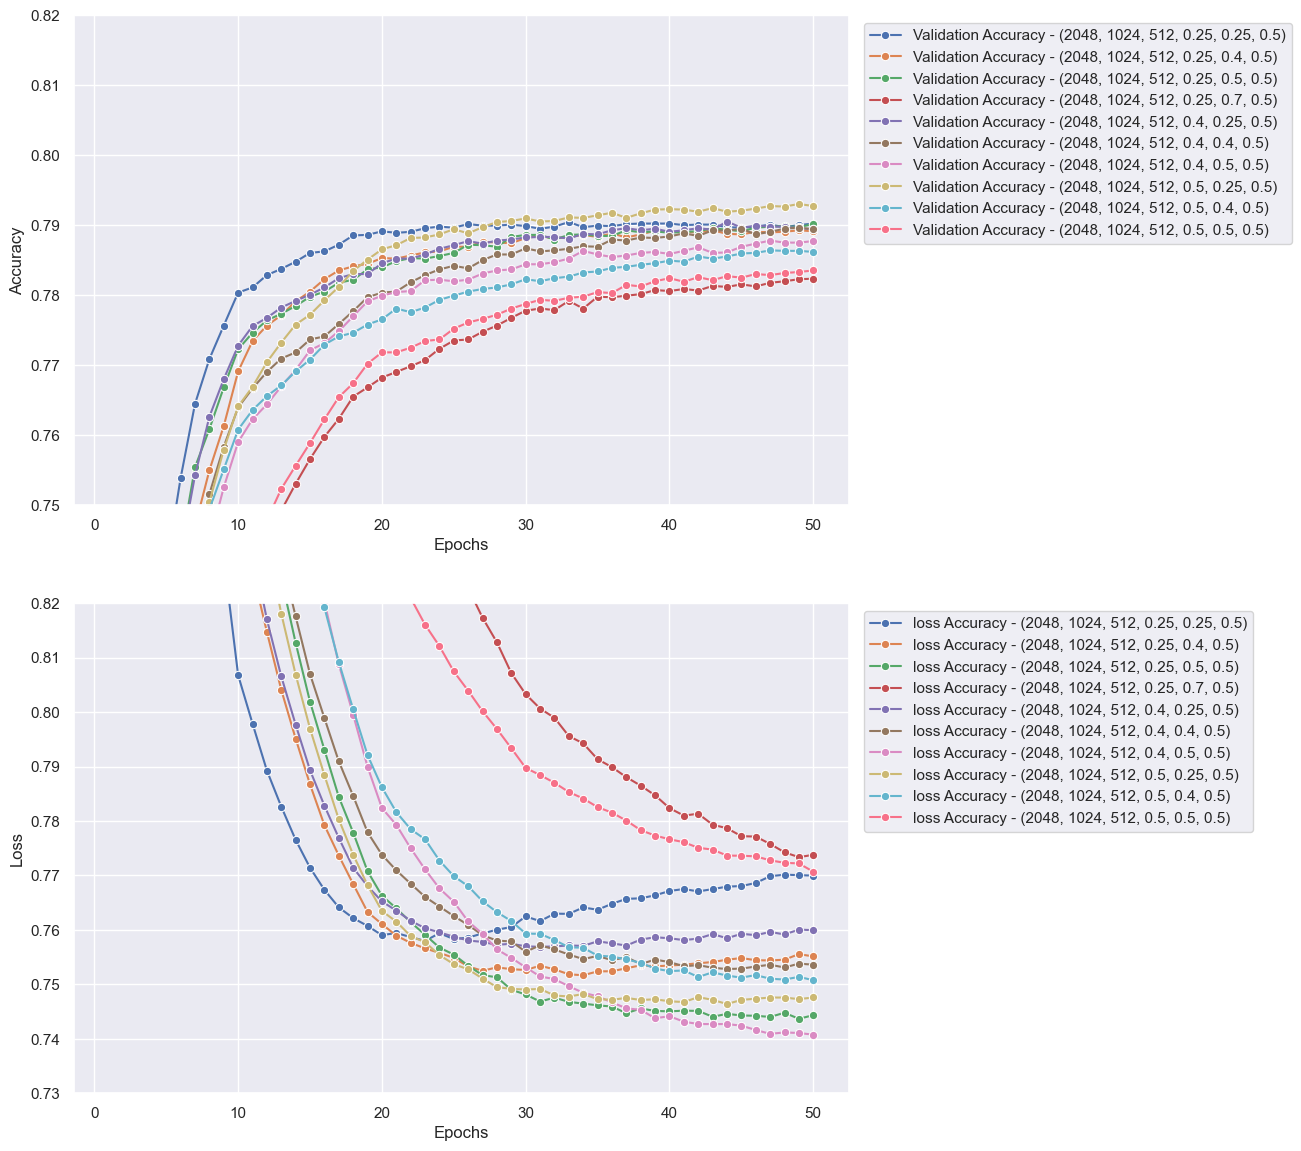

In [270]:
art1 = sns.color_palette()
art2 = sns.color_palette("husl", 9)
art3 = sns.color_palette("flare")
art4 = sns.color_palette("pastel")

art = art1 + art2 + art3 + art4

fig, axs = plt.subplots(2,1,figsize=(10,14))

for i in range(len(training_history)): #len(training_history)
    
    train_acc_hist = training_history[i].history['accuracy']
    val_acc_hist = training_history[i].history['val_accuracy']
    train_loss_hist = training_history[i].history['loss']
    val_loss_hist = training_history[i].history['val_loss']

    hist_params = str(results['param_trained'][i])
    
    best_val_acc = max(val_acc_hist)
    if best_val_acc > 0.78:
        color =  art[i]
    #     sns.lineplot(x = x_epochs, y = train_acc_hist, color = color, ls = ':', label = 'Training Accuracy - ' + hist_params)
        sns.lineplot(x = x_epochs, y = val_acc_hist, color = color, marker = 'o', ax=axs[0], label = 'Validation Accuracy - ' + hist_params)
        sns.lineplot(x = x_epochs, y = val_loss_hist, color = color, marker = 'o', ax=axs[1],label = 'loss Accuracy - ' + hist_params)
#         sns.lineplot(x = x_epochs, y = val_loss_hist, color = color, marker = 'o', label = 'Validation Loss - ' + hist_params)
ax=axs[0]
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(bbox_to_anchor=(1.01, 1.0))
ax.set_ylim(0.75,0.82)

ax=axs[1]
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(bbox_to_anchor=(1.01, 1.0))
ax.set_ylim(0.73,0.82)


# plt.title('Accuracy Evolution during training: NN_clf')
#
# plt.ylim(0.54,0.62)

In [231]:
# param_trained2 = []
# for drop0 in drop_range:
#     for drop1 in drop_range:
#         if 2<3:
#             for drop2 in [0.5]:
                
#                 param_trained2.append( (2048, u1, u2, drop0, drop1, drop2 ) )
# param_trained2

[(2048, 1024, 512, 0.25, 0.25, 0.5),
 (2048, 1024, 512, 0.25, 0.4, 0.5),
 (2048, 1024, 512, 0.25, 0.5, 0.5),
 (2048, 1024, 512, 0.25, 0.7, 0.5),
 (2048, 1024, 512, 0.4, 0.25, 0.5),
 (2048, 1024, 512, 0.4, 0.4, 0.5),
 (2048, 1024, 512, 0.4, 0.5, 0.5),
 (2048, 1024, 512, 0.4, 0.7, 0.5),
 (2048, 1024, 512, 0.5, 0.25, 0.5),
 (2048, 1024, 512, 0.5, 0.4, 0.5),
 (2048, 1024, 512, 0.5, 0.5, 0.5),
 (2048, 1024, 512, 0.5, 0.7, 0.5),
 (2048, 1024, 512, 0.7, 0.25, 0.5),
 (2048, 1024, 512, 0.7, 0.4, 0.5),
 (2048, 1024, 512, 0.7, 0.5, 0.5),
 (2048, 1024, 512, 0.7, 0.7, 0.5)]

In [233]:

results = {'param_trained' : param_trained,
           'train_histories' : train_histories,
           'accuracy_train' : acc_train,
           'accuracy_test' : acc_test,
           'loss_train' : losses_train,
           'loss_test' : losses_test}

result2 = {}
## parameter of the model trained
result2['param_trained'] = results['param_trained'] 
result2['d0_units'] = [ item[0] for item in results['param_trained']]
result2['d1_units'] = [ item[1] for item in results['param_trained']]
result2['d2_units'] = [ item[2] for item in results['param_trained']]
result2['drop0'] = [ item[3] for item in results['param_trained']]
result2['drop1'] = [ item[4] for item in results['param_trained']]
result2['drop2'] = [ item[5] for item in results['param_trained']]

## get history metrics: accuracy and loss for train and validation set
train_acc_h = []
val_acc_h = []
train_loss_h = []
val_loss_h = []
for i in range(len(training_history)):
    
    train_acc_h.append(list(training_history[i].history['accuracy']))
    val_acc_h.append(list(training_history[i].history['val_accuracy']))
    train_loss_h.append(list(training_history[i].history['loss']))
    val_loss_h.append(list(training_history[i].history['val_loss']))
    
result2['train_acc_hist'] = train_acc_h
result2['val_acc_hist'] = val_acc_h
result2['train_loss_hist'] = train_loss_h
result2['val_loss_hist'] = val_loss_h


## get final metrics, of the best model (checkpoint tracks best val acc)
## evaluated on the train and test sets.
result2['accuracy_train_opt'] = results['accuracy_train'] 
result2['accuracy_test_opt'] = results['accuracy_test'] 
result2['loss_train_opt'] = results['loss_train'] 
result2['loss_test_opt'] = results['loss_test'] 


result2
result2_df = pd.DataFrame(result2)

In [234]:
result2_df

,param_trained,d0_units,d1_units,d2_units,drop0,drop1,drop2,train_acc_hist,val_acc_hist,train_loss_hist,val_loss_hist,accuracy_train_opt,accuracy_test_opt,loss_train_opt,loss_test_opt
0,"(2048, 1024, 512, 0.25, 0.25, 0.5)",2048,1024,512,0.25,0.25,0.5,"[0.10777440667152405, 0.34339866042137146, 0.5...","[0.32126298546791077, 0.602414071559906, 0.683...","[3.6287143230438232, 2.3811373710632324, 1.676...","[2.6941475868225098, 1.6838840246200562, 1.317...",0.978066,0.787624,0.092276,0.773528
1,"(2048, 1024, 512, 0.25, 0.4, 0.5)",2048,1024,512,0.25,0.40,0.5,"[0.10153648257255554, 0.2906431257724762, 0.46...","[0.32001176476478577, 0.579745352268219, 0.661...","[3.6909444332122803, 2.6018035411834717, 1.923...","[2.694636583328247, 1.7931571006774902, 1.4173...",0.976539,0.788212,0.099387,0.763031
2,"(2048, 1024, 512, 0.25, 0.5, 0.5)",2048,1024,512,0.25,0.50,0.5,"[0.10008280724287033, 0.2638145089149475, 0.42...","[0.21270331740379333, 0.5717229843139648, 0.66...","[3.6933672428131104, 2.7184743881225586, 2.079...","[2.93337082862854, 1.905126690864563, 1.512597...",0.974459,0.789979,0.112478,0.756228
3,"(2048, 1024, 512, 0.25, 0.7, 0.5)",2048,1024,512,0.25,0.70,0.5,"[0.06788112968206406, 0.16200202703475952, 0.2...","[0.14190034568309784, 0.4665489196777344, 0.57...","[3.9584803581237793, 3.2437500953674316, 2.701...","[3.058934450149536, 2.2793033123016357, 1.8806...",0.959812,0.778026,0.200161,0.791880
4,"(2048, 1024, 512, 0.4, 0.25, 0.5)",2048,1024,512,0.40,0.25,0.5,"[0.08302512019872665, 0.2673659026622772, 0.44...","[0.17568263411521912, 0.5423566699028015, 0.64...","[3.88138747215271, 2.711013078689575, 1.998211...","[2.9551455974578857, 1.8973350524902344, 1.481...",0.975471,0.789096,0.099543,0.771069
5,"(2048, 1024, 512, 0.4, 0.4, 0.5)",2048,1024,512,0.40,0.40,0.5,"[0.09540896117687225, 0.25387799739837646, 0.4...","[0.2977846562862396, 0.5773901343345642, 0.649...","[3.7198519706726074, 2.7681732177734375, 2.128...","[2.7612156867980957, 1.8491305112838745, 1.483...",0.971957,0.785740,0.114171,0.764542
6,"(2048, 1024, 512, 0.4, 0.5, 0.5)",2048,1024,512,0.40,0.50,0.5,"[0.06237924471497536, 0.1715521216392517, 0.31...","[0.1619930863380432, 0.479870468378067, 0.6006...","[4.019782066345215, 3.1539499759674072, 2.4938...","[3.029543399810791, 2.157188892364502, 1.71071...",0.967817,0.786328,0.140923,0.751364
7,"(2048, 1024, 512, 0.4, 0.7, 0.5)",2048,1024,512,0.40,0.70,0.5,"[0.06096237152814865, 0.12661698460578918, 0.2...","[0.12946198880672455, 0.4179730713367462, 0.55...","[4.046781539916992, 3.4506747722625732, 2.9610...","[3.085315704345703, 2.4283699989318848, 2.0300...",0.946600,0.774435,0.253601,0.811773
8,"(2048, 1024, 512, 0.5, 0.25, 0.5)",2048,1024,512,0.50,0.25,0.5,"[0.09561137109994888, 0.25376760959625244, 0.4...","[0.24751600623130798, 0.5608301758766174, 0.64...","[3.7155849933624268, 2.754521369934082, 2.1206...","[2.787503957748413, 1.8723118305206299, 1.4973...",0.971313,0.787683,0.110077,0.759013
9,"(2048, 1024, 512, 0.5, 0.4, 0.5)",2048,1024,512,0.50,0.40,0.5,"[0.06780752539634705, 0.17755083739757538, 0.3...","[0.1017884761095047, 0.5088687539100647, 0.630...","[3.9435997009277344, 3.116995096206665, 2.4892...","[3.0541999340057373, 2.1364665031433105, 1.688...",0.967946,0.785033,0.135499,0.759801


In [235]:
vggt.save(datasets = [result2_df], 
             types = ['dataframe'], 
             names = ['FusionModel_grid_result_Fix-u0u1u2dr2_Var-dr0dr1'],  
              path = '../fm/Trained_models/fusion_model/', 
              doit = True, verbose = True)

Saved dataset: ../fm/Trained_models/fusion_model/2308290952_FusionModel_grid_result_Fix-u0u1u2dr2_Var-dr0dr1.csv


## 4.7 Make new predictions

## 6 Compare fusion model to Base models

### Barplot - Accuracy comparison

In [104]:
fusion_vs_base_models = {'models'     : ['NN', 'VGG+NN', 'FUSION'],
                       'train_acc'  : [0.878, 0.757, 0.919],
                       'test_acc'   : [0.773, 0.593, 0.819],
                       'train_time' : [52.60, 846.72, 800],  # seconds
                       'predict_time' : [2.17, 1.5, 2.72]}  # seconds


fusion_vs_base_df = pd.DataFrame(fusion_vs_base_models)

fusion_vs_base_df['model_id'] = fusion_vs_base_df.index + 1

fusion_vs_base_df

,models,train_acc,test_acc,train_time,predict_time,model_id
0,NN,0.878,0.773,52.60,2.17,1
1,VGG+NN,0.757,0.593,846.72,1.50,2
2,FUSION,0.919,0.819,800.00,2.72,3


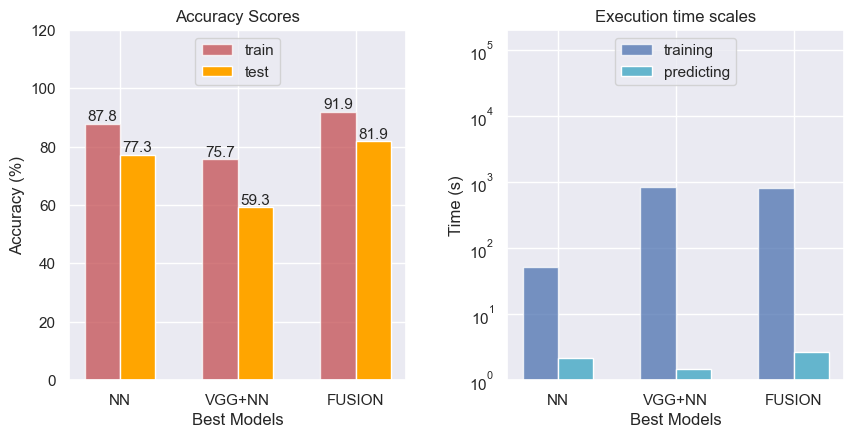

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

art = sns.color_palette()

# barWidth = 0.3
# x0 = range(1, len(text_models_df)+1, 1)
# x1 = [ x - 0.5*barWidth for x in x0 ]
# x2 = [ x + 0.5*barWidth for x in x0 ]

# fig, axs = plt.subplots(1,2,figsize=(10,3.5), )

# axs[0].bar(x1, text_models_df['train_acc'], width = barWidth, label='train', color = art[3], alpha = 0.75)
# axs[0].bar(x2, text_models_df['test_acc'], width = barWidth, label='test', color = 'orange')

barWidth = 0.3
x0 = range(1,len(fusion_vs_base_df)+1, 1)
x1 = [ x - 0.5*barWidth for x in x0 ]
x2 = [ x + 0.5*barWidth for x in x0 ]

fig, axs = plt.subplots(1,2,figsize=(10,3.5*1.3), )

# axs[0].bar_label(ax.containers[0], labels = values, label_type='edge', fontsize = 10)
p1 = axs[0].bar(x1, fusion_vs_base_df['train_acc']*100, width = barWidth, label='train', color = art[3], alpha = 0.75)
p2 = axs[0].bar(x2, fusion_vs_base_df['test_acc']*100, width = barWidth, label='test', color = 'orange')

label_train = [str(round(val*100,1)) for val in fusion_vs_base_df['train_acc']] 
label_test = [str(round(val*100,1)) for val in fusion_vs_base_df['test_acc']] 
axs[0].bar_label(p1, labels = label_train, label_type='edge', fontsize = 11, rotation = 0, padding = 0) #fmt='%.2f'
axs[0].bar_label(p2, labels = label_test, label_type='edge', fontsize = 11, rotation = 0, padding = 0)

axs[0].set_ylabel("Accuracy (%)")
axs[0].set_ylim(0,120)
axs[0].legend(loc = 'upper center')
axs[0].set_title("Accuracy Scores")


axs[1].bar(x1, fusion_vs_base_df['train_time'], width = barWidth, label='training', color = art[0], alpha = 0.75)
axs[1].bar(x2, fusion_vs_base_df['predict_time'], width = barWidth, label='predicting', color = art[9])

axs[1].set_ylabel("Time (s)")
axs[1].set_yscale('log')
axs[1].set_ylim(1,2e5)
axs[1].legend(loc = 'upper center')
axs[1].set_title("Execution time scales")

for ax in axs:
    ax.set_xlabel("Best Models")
    ax.set_xticks(ticks = x0, labels=fusion_vs_base_df['models'])

plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()